
# Productividad de pozos

Analisis estadístico y simulación de gasto en pozos. 

Información de producción histórica de hidrocarburos de la CNH.

In [23]:
from __future__ import division

import warnings


from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar


#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [24]:
import chart_studio
chart_studio.tools.set_credentials_file(username='ffftelias', api_key='••••••••••')

import chart_studio.plotly as py
import plotly.graph_objects as go

In [25]:
warnings.filterwarnings("ignore")

In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

import timeit

import ruptures as rpt

In [27]:
pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.6f}'.format

# Función Productividad de pozos

In [44]:
def productividad():
    
    global campo
    global unique_well_list
    global input_campo
    global well_data
    global results
    global vector
    
    tic=timeit.default_timer()
    
###########      DISTRIBUCION DE PROBABILIDAD   ####### 
    
    class Distribution(object):
    
        def __init__(self,dist_names_list = []):
            self.dist_names = ['beta',
                                'expon',
                                'gamma',
                                'lognorm',
                                'norm',
                                'pearson3',
                                'triang',
                                'uniform',
                                'weibull_min', 
                                'weibull_max']
            self.dist_results = []
            self.params = {}

            self.DistributionName = ""
            self.PValue = 0
            self.Param = None

            self.isFitted = False


        def Fit(self, y):
            self.dist_results = []
            self.params = {}
            for dist_name in self.dist_names:
                dist = getattr(scipy.stats, dist_name)
                param = dist.fit(y)

                self.params[dist_name] = param
                #Applying the Kolmogorov-Smirnov test
                D, p = scipy.stats.kstest(y, dist_name, args=param);
                self.dist_results.append((dist_name,p))
            #select the best fitted distribution
            sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
            #store the name of the best fit and its p value
            self.DistributionName = sel_dist
            self.PValue = p

            self.isFitted = True
            return self.DistributionName,self.PValue

        def Random(self, n = 1):
            if self.isFitted:
                dist_name = self.DistributionName
                param = self.params[dist_name]
                #initiate the scipy distribution
                dist = getattr(scipy.stats, dist_name)
                return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
            else:
                raise ValueError('Must first run the Fit method.')

        def Plot(self,y):
            x = self.Random(n=len(y))
            fig, ax = plt.subplots(figsize=(16,8))
            plt.hist(x, alpha=0.5, label='Fitted',bins=50)
            plt.hist(y, alpha=0.5, label='Actual',bins=50)
            plt.legend(loc='upper right')

    
#############      ESTADISTICA DE POZOS   ####### 
    
    
    #Carga de datos   
    mx_stats=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/mx_bd.csv',
                         #index_col=1,
                         low_memory=False)
    
    display('Numero de datos en BD: '+str(len(mx_stats)))
    
    #Input de campo
    input_campo = input("Nombre de Campo: ")
    
    selected_rows=mx_stats.pozo.str.contains(str(input_campo))
    campo=mx_stats.loc[selected_rows]

    display('Numero de datos para '+str(input_campo)+': ' +str(len(campo)))
    
    unique_well_list=pd.unique(campo['pozo'])

    display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)),
            unique_well_list)
    
    #Estadistica descriptiva
    display('Percentiles y estadistica descriptiva: ')
    display(campo.aceite_Mbd.quantile([.1,.5,.9]),
            campo.describe())  
    
    #Analisis de dispersion
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(campo.pozo,campo.aceite_Mbd)
    ax.set_xlabel('Pozo')
    ax.set_xticklabels(labels=campo.pozo,rotation=90)
    ax.set_ylabel('Gasto de aceite Mbd')
    plt.show()
    
    #Ajuste de distribucion
    dst=Distribution()
    display(dst.Fit(campo.aceite_Mbd))
    dst.Plot(campo.aceite_Mbd)
    
    #Generacion de archivo de resultados
    campo.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

########      ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
        global value
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):
        global df_beginning_production
        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hyperbolic_equation(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponential_equation(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonic_equation (t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot results
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    results=pd.DataFrame()
    vector=pd.DataFrame()
    gasto=pd.DataFrame()
    
    #Read the oil and gas data
    well_data=campo
    #Perform some data cleaning to get the columns as the right data type
    well_data['fecha']=pd.to_datetime(well_data['fecha'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    hydrocarbon='aceite_Mbd'
    #Remove all rows with null values in the desired time series column
    well_data=remove_nan_and_zeroes_from_columns(well_data, hydrocarbon)
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(well_data.pozo))
    #Get the earliest RecordDate for each Well
    well_data['first_oil']= get_min_or_max_value_in_column_by_group(well_data, group_by_column='pozo', 
                                                                    calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    well_data['days_online']=generate_time_delta_column(well_data, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    well_data_range=well_data[(well_data.fecha>='1900-01-01') & (well_data.fecha<='2019-12-01')]
    
    #Loop through each well, and perform calculations
    for pozo in unique_well_list:
        #Subset the dataframe by Well
        production_time_series=well_data_range[well_data_range.pozo==pozo]
        #Get the highest value of production in the first X months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 24, hydrocarbon, 'fecha')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,2,10]))
        print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Harmonic curve fit the data to get best fit equation
        popt_harm, pcov_harm=curve_fit(harmonic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['days_online'], 
                                  *popt_exp)

        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['days_online'], 
                                  *popt_hyp)
        #Harmonic fit results
        production_time_series.loc[:,'Harmonic_Predicted']=harmonic_equation(production_time_series['days_online'], 
                                  *popt_harm)
        
        #Error
        perr = np.sqrt(np.diag(pcov_harm))

        production_time_series.loc[:,'Qi_harmonic']=popt_harm[0]
        production_time_series.loc[:,'di_harmonic']=popt_harm[1]
        production_time_series.loc[:,'Error Qo_harmonic']=perr[0]
        production_time_series.loc[:,'Error di_harmonic']=perr[1]
        production_time_series.loc[:,'month']=(production_time_series['aceite_Mbd'] > 0).cumsum()
        
        gasto=[[pozo,qi]]
        display(gasto)

        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon,'Hyperbolic_Predicted','Exponential_Predicted','Harmonic_Predicted']
        x_variable='month'
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)

        results=results.append(production_time_series,sort=True)
        vector=vector.append(gasto,sort=True)
    
    #####################  RESULTADOS DCA   #####################

    results.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
    
    vector=vector.rename(columns={0:'pozo',1:'qi'}).set_index('pozo')
    vector.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/gasto.csv')
    
    fig2, ax2 = plt.subplots(figsize=(16,8))
    plt.hist(results.aceite_Mbd, alpha=0.5, label='Qo Historico',bins=50)
    plt.hist(results.Hyperbolic_Predicted, alpha=0.5, label='Hyperbolic Predicted',bins=50)
    plt.legend(loc='upper right')
    
    #results=results.groupby(by='pozo')
    fig3, ax3 = plt.subplots(figsize=(16,8))
    ax3.scatter(results.month,results.aceite_Mbd,cmap='viridis')
    ax3.set_xlabel('month')
    ax3.set_ylabel('Qo')
    plt.show()

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

'Numero de datos en BD: 2851710'

Nombre de Campo: MIQUETLA


'Numero de datos para MIQUETLA: 24691'

'Número de pozos en MIQUETLA: 137'

array(['MIQUETLA-122', 'MIQUETLA-57', 'MIQUETLA-64', 'MIQUETLA-2',
       'MIQUETLA-3', 'MIQUETLA-4', 'MIQUETLA-5', 'MIQUETLA-6',
       'MIQUETLA-7', 'MIQUETLA-8', 'MIQUETLA-9', 'MIQUETLA-11',
       'MIQUETLA-12', 'MIQUETLA-13', 'MIQUETLA-14', 'MIQUETLA-15',
       'MIQUETLA-16', 'MIQUETLA-17', 'MIQUETLA-18', 'MIQUETLA-19',
       'MIQUETLA-20', 'MIQUETLA-21', 'MIQUETLA-22', 'MIQUETLA-23',
       'MIQUETLA-23A', 'MIQUETLA-24', 'MIQUETLA-25', 'MIQUETLA-26',
       'MIQUETLA-27', 'MIQUETLA-28', 'MIQUETLA-29', 'MIQUETLA-30',
       'MIQUETLA-31', 'MIQUETLA-32', 'MIQUETLA-33', 'MIQUETLA-34',
       'MIQUETLA-35', 'MIQUETLA-36', 'MIQUETLA-37', 'MIQUETLA-38',
       'MIQUETLA-39', 'MIQUETLA-40', 'MIQUETLA-41', 'MIQUETLA-42',
       'MIQUETLA-43', 'MIQUETLA-44', 'MIQUETLA-45', 'MIQUETLA-46',
       'MIQUETLA-47', 'MIQUETLA-48', 'MIQUETLA-49', 'MIQUETLA-50',
       'MIQUETLA-51', 'MIQUETLA-52', 'MIQUETLA-54', 'MIQUETLA-55',
       'MIQUETLA-56', 'MIQUETLA-92', 'MIQUETLA-58', 'MIQUETLA-59',
 

'Percentiles y estadistica descriptiva: '

0.100000   0.003449
0.500000   0.014392
0.900000   0.043826
Name: aceite_Mbd, dtype: float64

Unnamed: 0    aceite_Mbd      agua_Mbd  condensado_Mbd  gas_asociado_MMpcd  gas_no_asociado_MMpcd  ANO DE PERFORACION                GID  PROFUNDIDAD TOTAL  PROFUNDIDAD VERTICAL
count  24,691.000000 24,691.000000 24,691.000000   24,691.000000       24,691.000000          24,691.000000       24,690.000000      24,690.000000      24,690.000000            437.000000
mean  388,584.431655      0.021345      0.003869        0.000000            0.039202               0.001600        1,963.501296     729,393.672337       2,074.495865          2,096.469108
std   253,863.180882      0.026547      0.014173        0.000000            0.066244               0.038658           11.386060   8,894,951.393778         121.508884            105.069230
min     3,513.000000      0.000000      0.000000        0.000000            0.000000               0.000000        1,948.000000     102,363.000000         500.000000          1,847.000000
25%   196,033.500000      0.007713      0.000000        0.000000            0.006828               0.000000        1,960.000000     105,632.000000       2,026.500000          2,073.000000
50%   309,204.000000      0.014392      0.000415        0.000000            0.018683               0.000000        1,961.000000     112,417.000000       2,062.000000          2,122.000000
75%   545,358.500000      0.025159      0.001834        0.000000            0.045539               0.000000        1,962.000000     118,251.000000       2,098.000000          2,141.000000
max   999,523.000000      0.719271      0.383272        0.000000            1.058039               1.693737        2,018.000000 129,862,952.000000       3,472.000000          2,209.000000

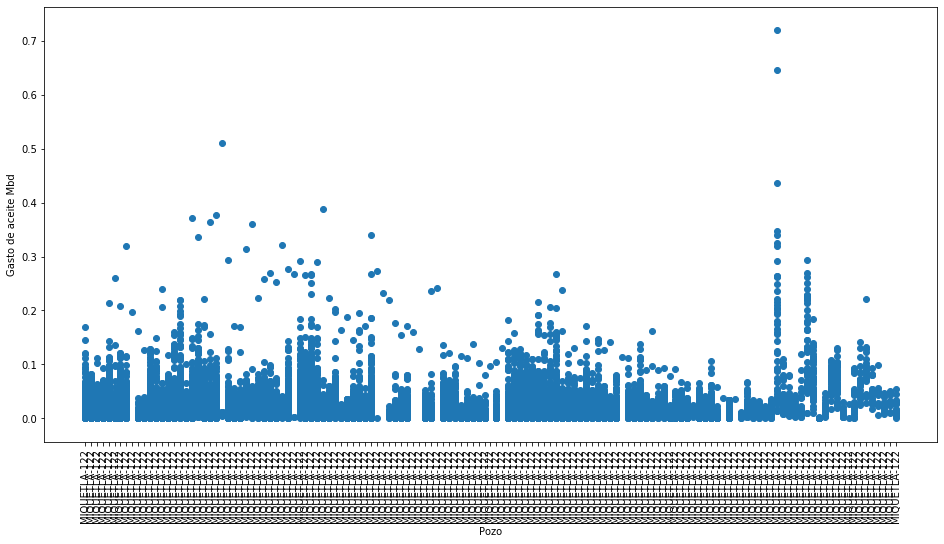

('lognorm', 4.987298569425703e-19)

Exponential Fit Curve-fitted Variables: qi=0.04849199740255956, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.04599381301096982, b=1.9999999999999998, di=0.0001432423645969773
Harmonic Fit Curve-fitted Variables: qi=0.03850689348697683, di=5.5183615304676774e-05


[['MIQUETLA-122', 0.086028]]

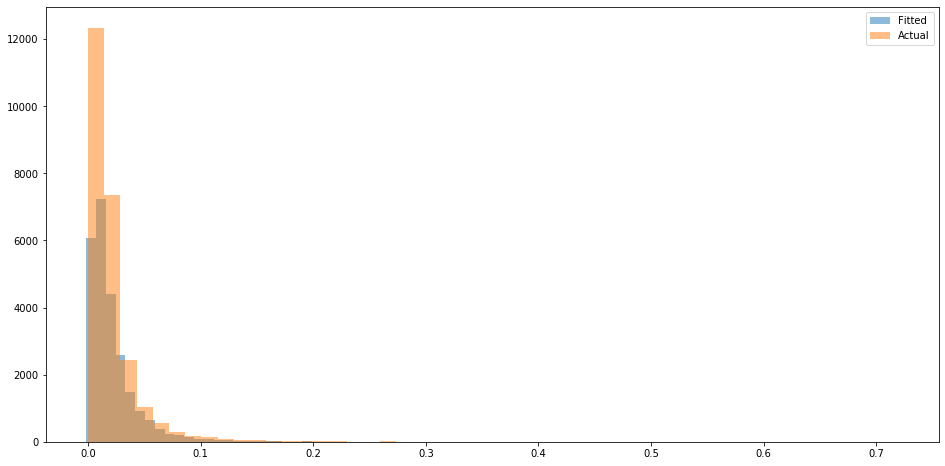

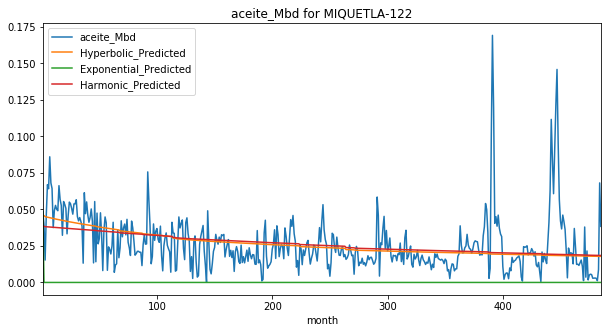

Exponential Fit Curve-fitted Variables: qi=0.06898492467399887, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.046294139243372605, b=1.134065035084218, di=0.00015200438961483295
Harmonic Fit Curve-fitted Variables: qi=0.0457519817446916, di=0.00013889689362678247


[['MIQUETLA-57', 0.075058]]

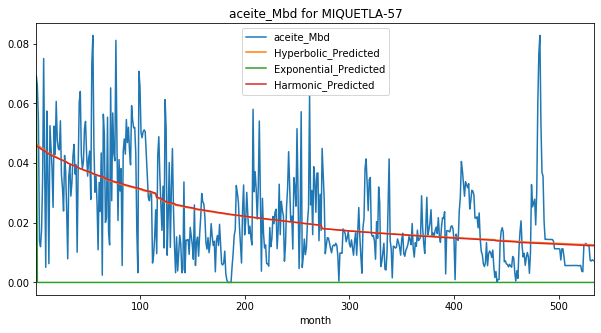

Exponential Fit Curve-fitted Variables: qi=0.10261587011718751, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.057854899547357265, b=1.9999999999999998, di=0.0013931241830824153
Harmonic Fit Curve-fitted Variables: qi=0.04227251121331182, di=0.00031054026028729643


[['MIQUETLA-64', 0.10266600000000001]]

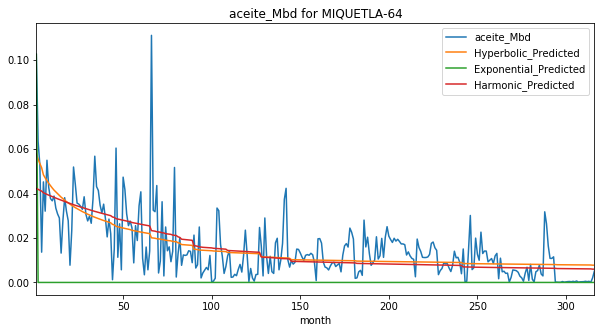

Exponential Fit Curve-fitted Variables: qi=0.015826000113570462, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.020528326658783933, b=2.6150785712869784e-07, di=1.5512830445803103e-05
Harmonic Fit Curve-fitted Variables: qi=0.02051310839039876, di=1.6967970601084363e-05


[['MIQUETLA-2', 0.045855]]

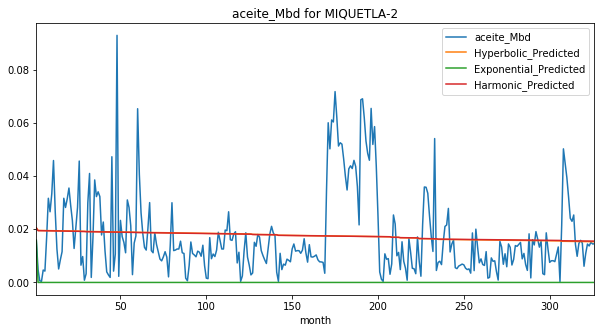

Exponential Fit Curve-fitted Variables: qi=0.2146395849609375, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.21146942832895838, b=1.2529377910576234, di=0.001325357536320091
Harmonic Fit Curve-fitted Variables: qi=0.20164988472585432, di=0.0008863544822279976


[['MIQUETLA-3', 0.214692]]

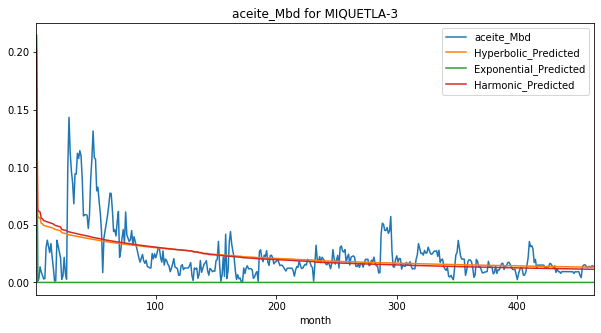

Exponential Fit Curve-fitted Variables: qi=0.25964459472656254, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.25970799999996924, b=0.44072502706470423, di=0.000834065098085685
Harmonic Fit Curve-fitted Variables: qi=0.25970799915849646, di=0.002032569937268253


[['MIQUETLA-4', 0.259708]]

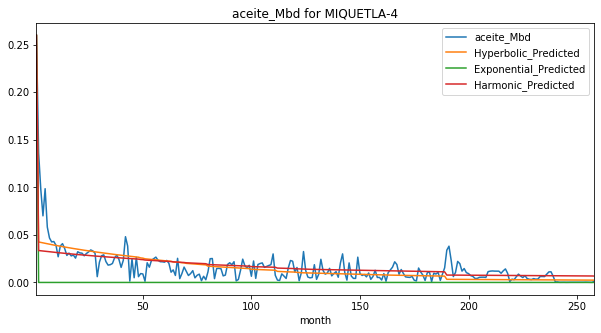

Exponential Fit Curve-fitted Variables: qi=0.20814117187500003, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.19913466781743366, b=1.9999999999999998, di=0.004326267069782042
Harmonic Fit Curve-fitted Variables: qi=0.031005978808447986, di=7.662961033719455e-18


[['MIQUETLA-5', 0.20819200000000002]]

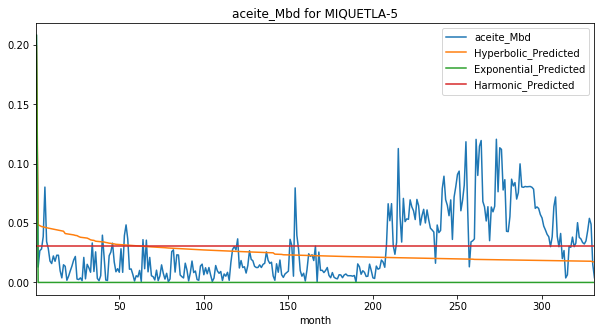

Exponential Fit Curve-fitted Variables: qi=0.3190790808105469, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.31915699999999064, b=0.18862348033128065, di=0.000568918059413168
Harmonic Fit Curve-fitted Variables: qi=0.31915699977975986, di=0.0017522577094607888


[['MIQUETLA-6', 0.319157]]

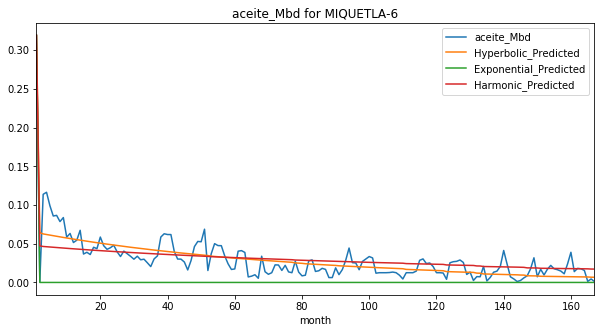

Exponential Fit Curve-fitted Variables: qi=0.197119703125, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.197119703125, b=1.0, di=5.0
Harmonic Fit Curve-fitted Variables: qi=0.197119703125, di=5.0


[['MIQUETLA-7', 0.197216]]

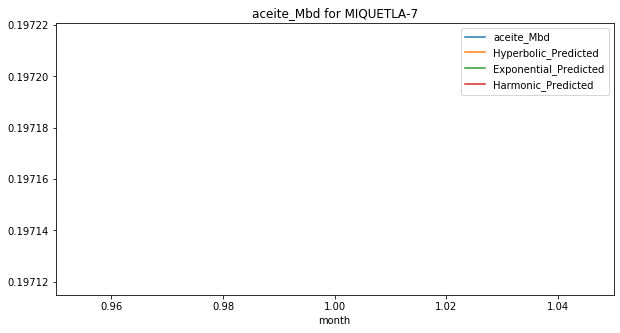

Exponential Fit Curve-fitted Variables: qi=0.16198786572265628, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.16206691845067211, b=1.293445464951703, di=0.0028719047053537756
Harmonic Fit Curve-fitted Variables: qi=0.1620617534863486, di=0.0015310538594876092


[['MIQUETLA-8', 0.16206700000000002]]

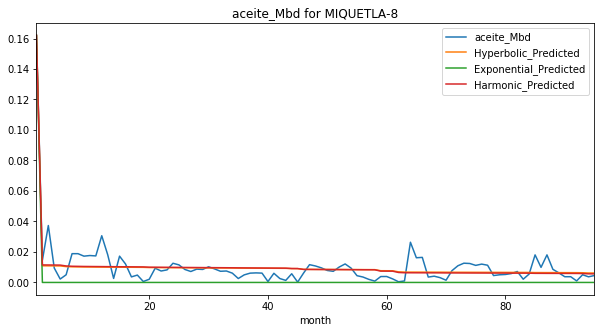

Exponential Fit Curve-fitted Variables: qi=0.12735678369140624, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.12728264661580527, b=1.9999999999999998, di=0.008107189676978873
Harmonic Fit Curve-fitted Variables: qi=0.12489622458456169, di=0.0012551628582229885


[['MIQUETLA-9', 0.127419]]

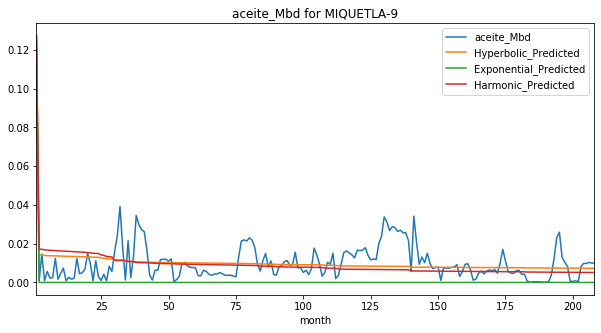

Exponential Fit Curve-fitted Variables: qi=0.12802494536875045, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.12831199999999995, b=1.100319145862e-14, di=0.0002796338396856232
Harmonic Fit Curve-fitted Variables: qi=0.12831199999999995, di=0.000624443737639365


[['MIQUETLA-11', 0.12831199999999998]]

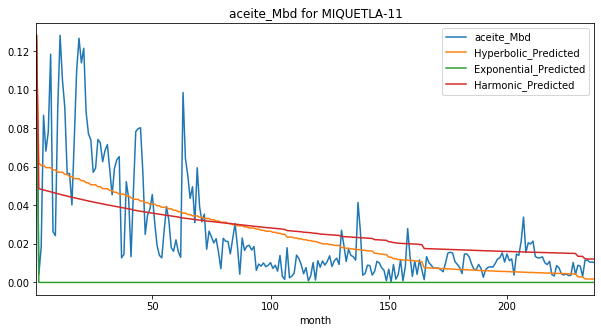

Exponential Fit Curve-fitted Variables: qi=0.14844748046875, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.1333480332837329, b=0.3738216912697338, di=0.0004310625007604715
Harmonic Fit Curve-fitted Variables: qi=0.14851999999974558, di=0.0009609239711633692


[['MIQUETLA-12', 0.14852]]

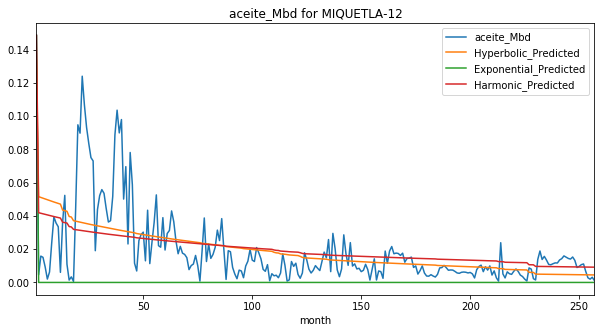

Exponential Fit Curve-fitted Variables: qi=0.23962748291015626, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.23913981405334203, b=1.4454958683181782, di=0.004998709290122332
Harmonic Fit Curve-fitted Variables: qi=0.235361902081004, di=0.0023106056377534684


[['MIQUETLA-13', 0.239686]]

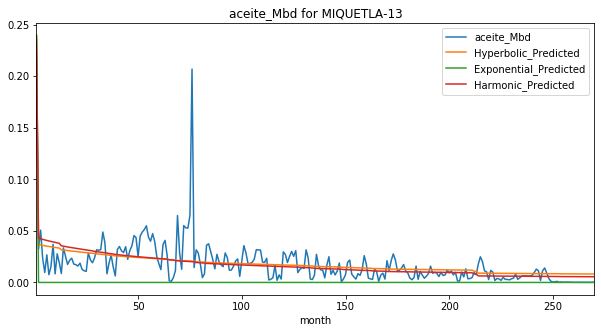

Exponential Fit Curve-fitted Variables: qi=0.05823100000054436, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.07606979751946022, b=0.21294084550438652, di=0.00029607756008689635
Harmonic Fit Curve-fitted Variables: qi=0.08294609897498413, di=0.0005918761730468668


[['MIQUETLA-14', 0.116666]]

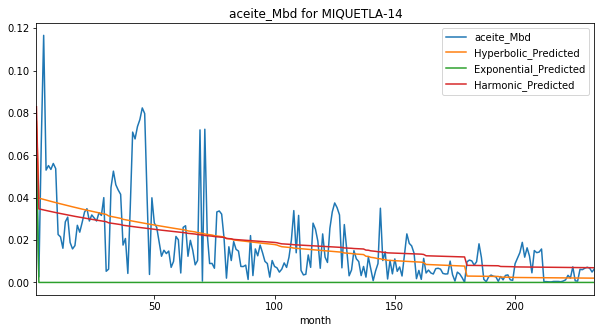

Exponential Fit Curve-fitted Variables: qi=0.10818499717068457, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.160085999999998, b=8.547780414424984e-15, di=0.00028540090646978004
Harmonic Fit Curve-fitted Variables: qi=0.16008599999953335, di=0.000669596063420093


[['MIQUETLA-15', 0.16008599999999998]]

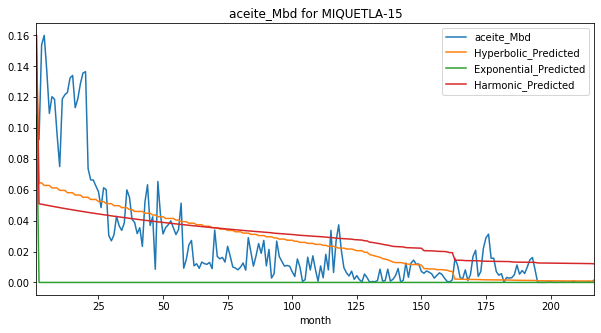

Exponential Fit Curve-fitted Variables: qi=0.09475301333287718, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.18654162495482232, b=7.473699112416e-15, di=0.00025652127995799755
Harmonic Fit Curve-fitted Variables: qi=0.19330103854602154, di=0.000617332932118934


[['MIQUETLA-16', 0.22014299999999998]]

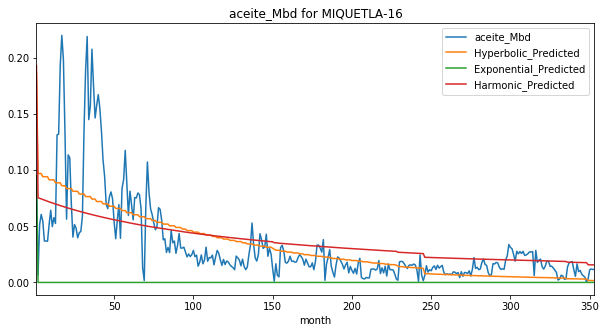

Exponential Fit Curve-fitted Variables: qi=0.06493152832031251, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.05989064232035813, b=1.9999999999999998, di=0.001160387611945353
Harmonic Fit Curve-fitted Variables: qi=0.016920257586774075, di=1.945922455132273e-05


[['MIQUETLA-17', 0.06499500000000001]]

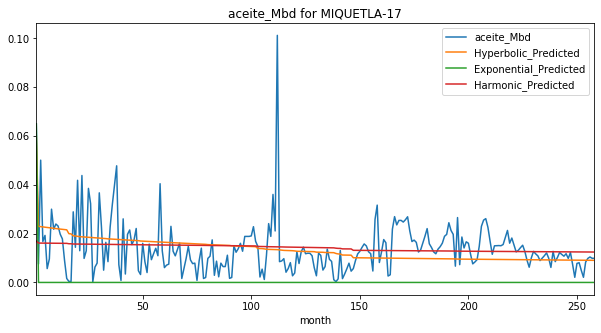

Exponential Fit Curve-fitted Variables: qi=0.3720221520996094, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.3721129999994342, b=0.7325299278300589, di=0.0010073588645909206
Harmonic Fit Curve-fitted Variables: qi=0.3721129994133274, di=0.0015256389495144917


[['MIQUETLA-18', 0.372113]]

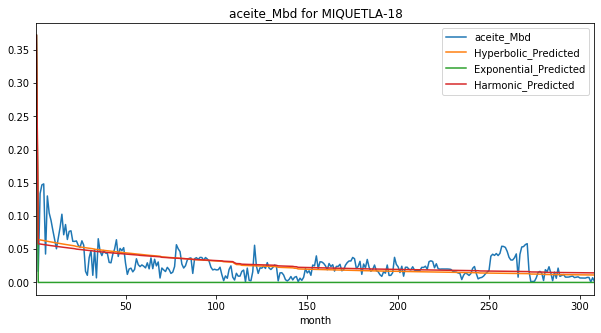

Exponential Fit Curve-fitted Variables: qi=0.3367267712402344, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.33070368872840367, b=1.0749506347240512, di=0.001196302662278399
Harmonic Fit Curve-fitted Variables: qi=0.3264795867517103, di=0.0010716917755279039


[['MIQUETLA-19', 0.336809]]

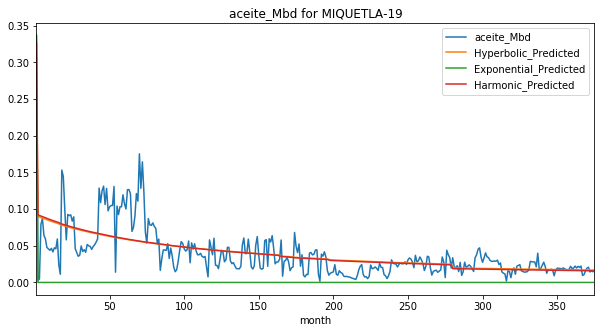

Exponential Fit Curve-fitted Variables: qi=0.2202992028808594, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.22035299999999944, b=0.48760309786932443, di=0.0008071813010167916
Harmonic Fit Curve-fitted Variables: qi=0.220353, di=0.0015199349929385822


[['MIQUETLA-20', 0.22035300000000002]]

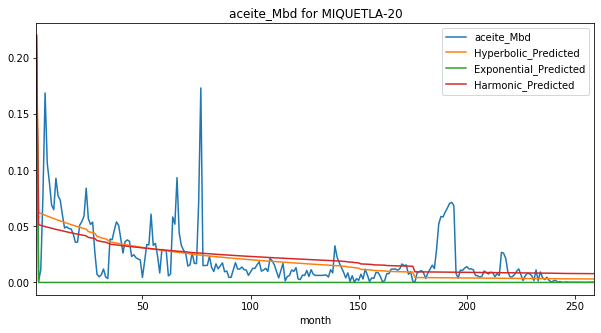

Exponential Fit Curve-fitted Variables: qi=0.3639081335449218, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.36345186558359344, b=1.1260317699194697, di=0.004058482100882447
Harmonic Fit Curve-fitted Variables: qi=0.362892718746469, di=0.003178866378674636


[['MIQUETLA-21', 0.36399699999999996]]

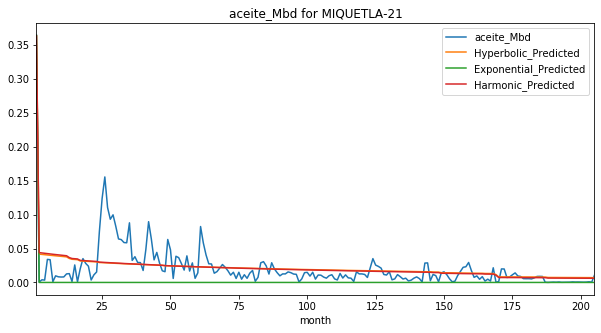

Exponential Fit Curve-fitted Variables: qi=0.37750581298828123, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.3756463589190173, b=0.9657807204315875, di=0.0024730296669232105
Harmonic Fit Curve-fitted Variables: qi=0.3761744524233007, di=0.002632268138700978


[['MIQUETLA-22', 0.377598]]

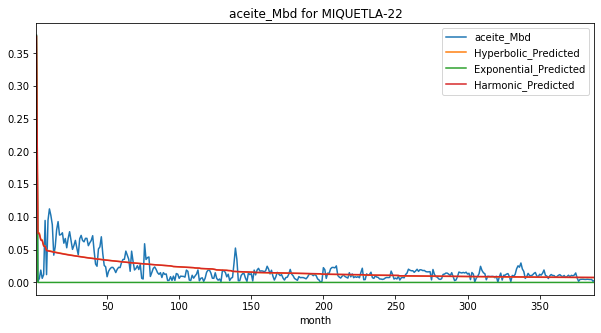

Exponential Fit Curve-fitted Variables: qi=0.5112375854492188, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.5112071102569897, b=1.9999999971600266, di=0.13647324180297285
Harmonic Fit Curve-fitted Variables: qi=0.5112687558610529, di=0.004164207445951699


[['MIQUETLA-23', 0.5113]]

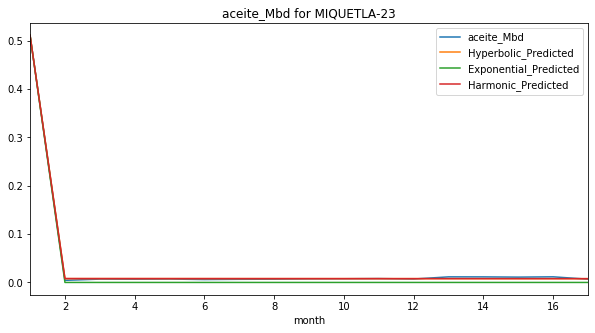

Exponential Fit Curve-fitted Variables: qi=0.293520322265625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.29359199999784885, b=0.8068076341403545, di=0.0013658456467196974
Harmonic Fit Curve-fitted Variables: qi=0.2935919999506614, di=0.0019072740453601764


[['MIQUETLA-23A', 0.293592]]

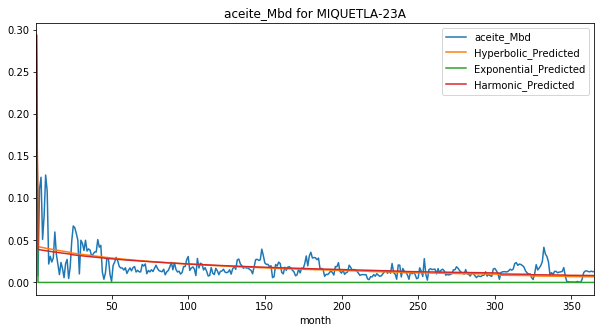

Exponential Fit Curve-fitted Variables: qi=0.17153820019531252, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.17131143915018288, b=1.9999999999999998, di=0.011060229606253896
Harmonic Fit Curve-fitted Variables: qi=0.1640382702415488, di=0.001908608443569831


[['MIQUETLA-24', 0.171622]]

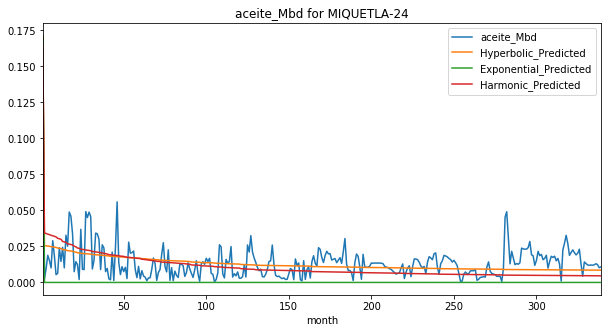

Exponential Fit Curve-fitted Variables: qi=0.168321771484375, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.16834713620416816, b=1.1711810902822177, di=0.001459767531471725
Harmonic Fit Curve-fitted Variables: qi=0.16808627619790156, di=0.0010959210487150796


[['MIQUETLA-25', 0.168404]]

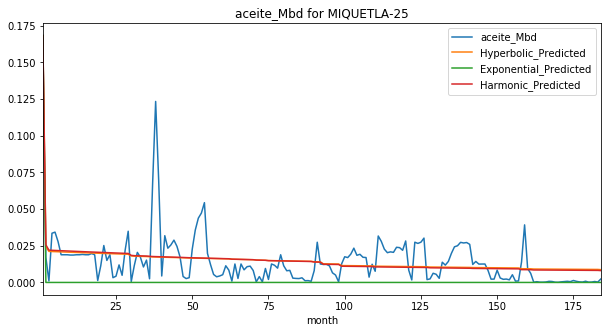

Exponential Fit Curve-fitted Variables: qi=0.3137843737792969, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.31358309201963397, b=1.9999999999999998, di=0.004397740663597021
Harmonic Fit Curve-fitted Variables: qi=0.31024650377153923, di=0.0007515292781530705


[['MIQUETLA-26', 0.313861]]

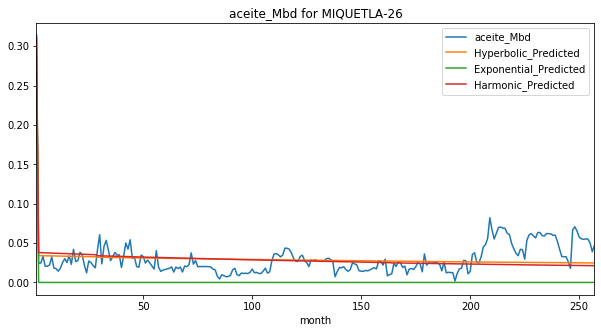

Exponential Fit Curve-fitted Variables: qi=0.3610678271484375, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.3611559526068897, b=0.8934538287155582, di=0.0009103910110777711
Harmonic Fit Curve-fitted Variables: qi=0.36114210664167723, di=0.0011136535242441314


[['MIQUETLA-27', 0.361156]]

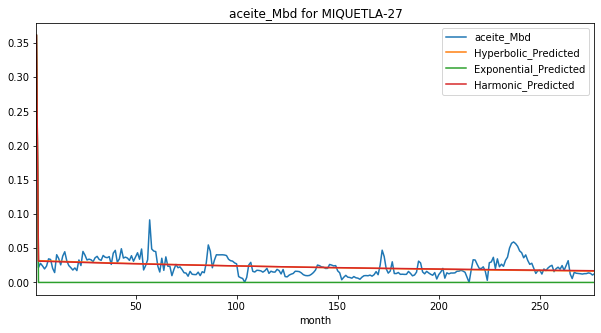

Exponential Fit Curve-fitted Variables: qi=0.22239469116210936, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.22244899991123793, b=1.7191299209330448, di=0.0014847765456146094
Harmonic Fit Curve-fitted Variables: qi=0.22158700591587438, di=0.0005250069851146162


[['MIQUETLA-28', 0.22244899999999998]]

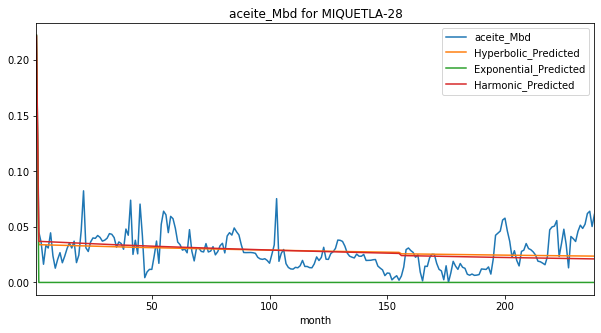

Exponential Fit Curve-fitted Variables: qi=0.25741313964843754, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.25740569033557703, b=1.9999999999999998, di=0.012753321361347013
Harmonic Fit Curve-fitted Variables: qi=0.2499023061112362, di=0.002164645893628414


[['MIQUETLA-29', 0.25747600000000004]]

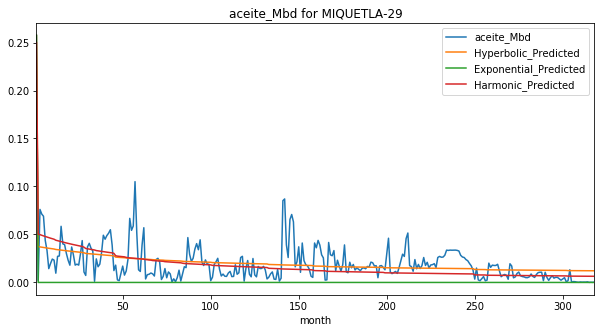

Exponential Fit Curve-fitted Variables: qi=0.2687723657226563, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.26756610038998807, b=1.166674855735774, di=0.0020779749354940622
Harmonic Fit Curve-fitted Variables: qi=0.2635953809490407, di=0.0016216329938359933


[['MIQUETLA-30', 0.268838]]

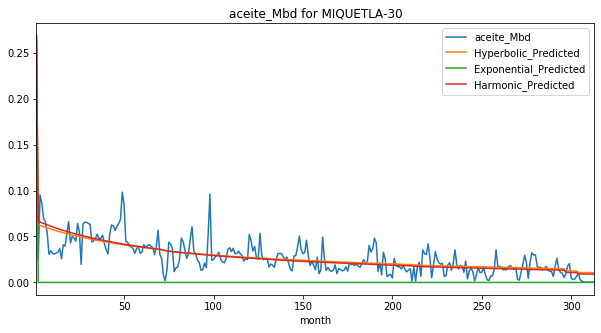

Exponential Fit Curve-fitted Variables: qi=0.2521594226074219, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2520769435474333, b=1.293548906345698, di=0.004479963062109177
Harmonic Fit Curve-fitted Variables: qi=0.2508206706773185, di=0.002685862804740068


[['MIQUETLA-31', 0.25222100000000003]]

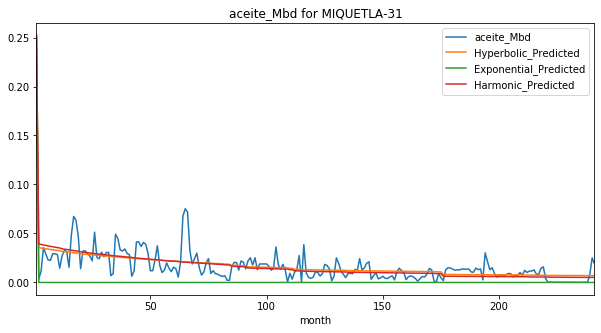

Exponential Fit Curve-fitted Variables: qi=0.3209046350097656, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.3209573849482371, b=1.9999999999999998, di=0.013805571311789737
Harmonic Fit Curve-fitted Variables: qi=0.3204767439222731, di=0.001428100785423233


[['MIQUETLA-32', 0.320983]]

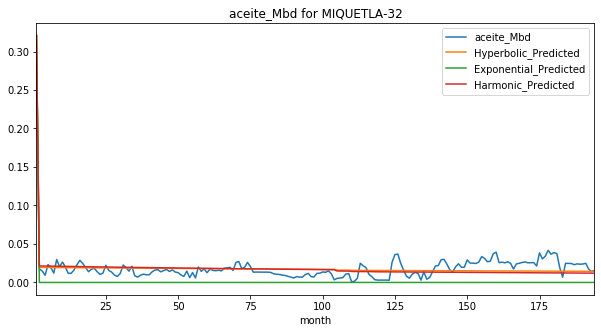

Exponential Fit Curve-fitted Variables: qi=0.2773122802734375, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.27737999999999996, b=3.128758766691111e-07, di=0.00040805851340236667
Harmonic Fit Curve-fitted Variables: qi=0.2773799999997632, di=0.0013403382470595624


[['MIQUETLA-33', 0.27738]]

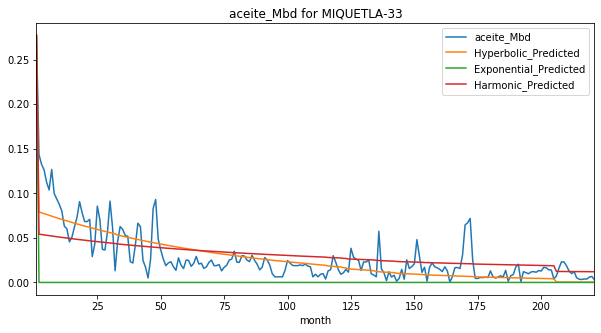

Exponential Fit Curve-fitted Variables: qi=0.26775861328124995, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2678065692259118, b=1.9958807306477457, di=1.095551722139768
Harmonic Fit Curve-fitted Variables: qi=0.2677586128583305, di=0.015040198928159687


[['MIQUETLA-34', 0.26782399999999995]]

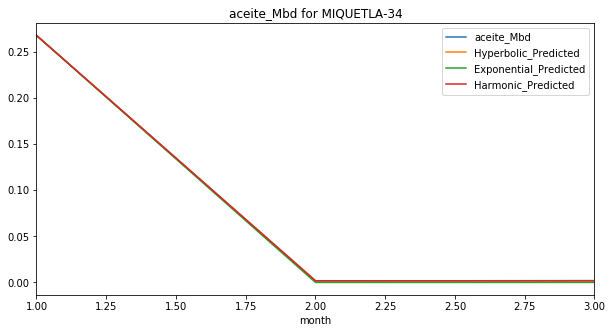

Exponential Fit Curve-fitted Variables: qi=0.2920996691894532, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.29217099980166505, b=1.109906217951101, di=0.0015845452445839281
Harmonic Fit Curve-fitted Variables: qi=0.2856022326891688, di=0.0013551159050572107


[['MIQUETLA-35', 0.292171]]

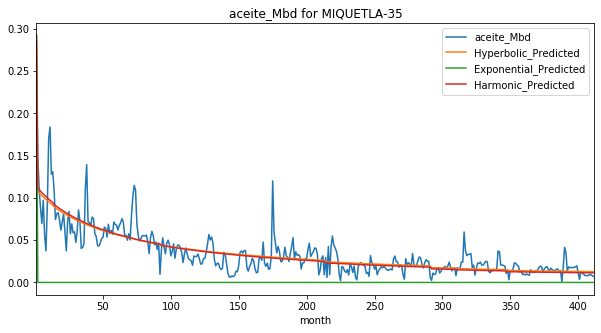

Exponential Fit Curve-fitted Variables: qi=0.26635295654296876, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2657712321519924, b=1.6519193588569419, di=0.0038485909934151846
Harmonic Fit Curve-fitted Variables: qi=0.25417107067952455, di=0.0013035463024007995


[['MIQUETLA-36', 0.266418]]

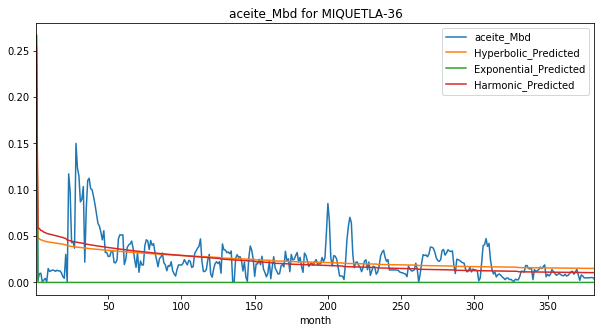

Exponential Fit Curve-fitted Variables: qi=0.2667438610839844, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.25783073617243096, b=2.8194235044460296e-08, di=0.00039137788914202096
Harmonic Fit Curve-fitted Variables: qi=0.26680899999999996, di=0.0009525536745198806


[['MIQUETLA-37', 0.266809]]

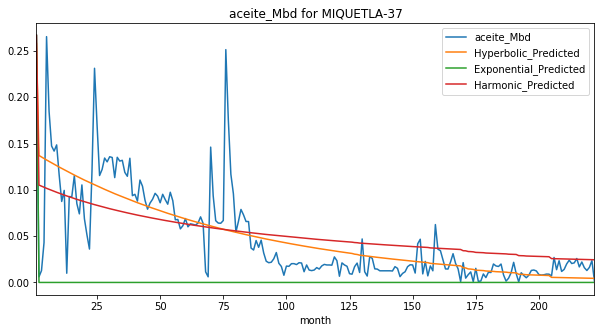

Exponential Fit Curve-fitted Variables: qi=0.2905180554199219, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2905889999999985, b=3.201981762095282e-08, di=0.00045101802738605943
Harmonic Fit Curve-fitted Variables: qi=0.29058899999999993, di=0.0014539743010244773


[['MIQUETLA-38', 0.290589]]

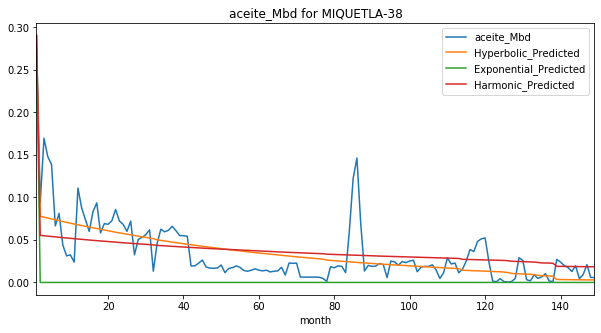

Exponential Fit Curve-fitted Variables: qi=0.3874383874511719, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.387518598264759, b=1.9999999999999998, di=0.029639597780877765
Harmonic Fit Curve-fitted Variables: qi=0.387211334601077, di=0.0024057881733665393


[['MIQUETLA-39', 0.387533]]

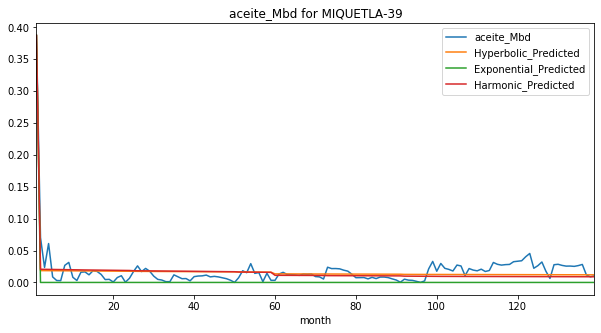

Exponential Fit Curve-fitted Variables: qi=0.22260463989257817, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.22257202775451593, b=1.9999999999999998, di=0.013926095395656517
Harmonic Fit Curve-fitted Variables: qi=0.22014810460219306, di=0.001969798998866181


[['MIQUETLA-40', 0.22265900000000002]]

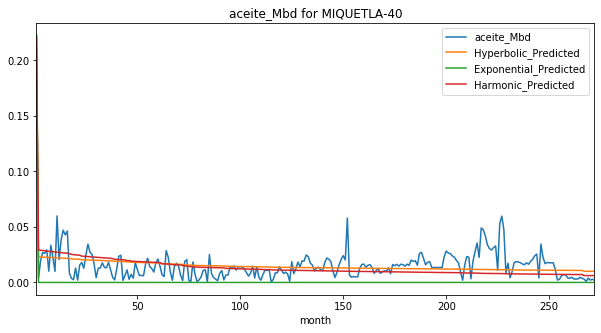

Exponential Fit Curve-fitted Variables: qi=0.19732260400390628, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.19712401819568595, b=1.6916288900196483, di=0.0027551626968985235
Harmonic Fit Curve-fitted Variables: qi=0.165536214737893, di=0.0009531831925151484


[['MIQUETLA-41', 0.197419]]

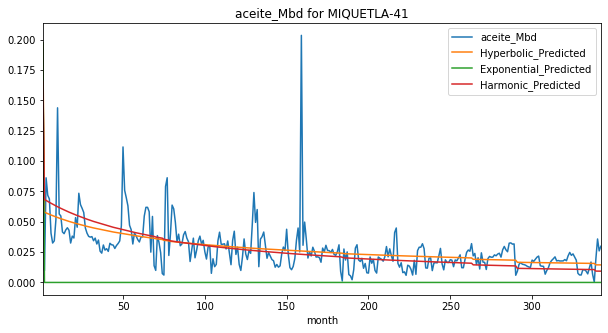

Exponential Fit Curve-fitted Variables: qi=0.16446865380859374, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.16452753495440842, b=1.9999999999999998, di=0.009018336503305045
Harmonic Fit Curve-fitted Variables: qi=0.16407100466986083, di=0.001194408052962008


[['MIQUETLA-42', 0.164549]]

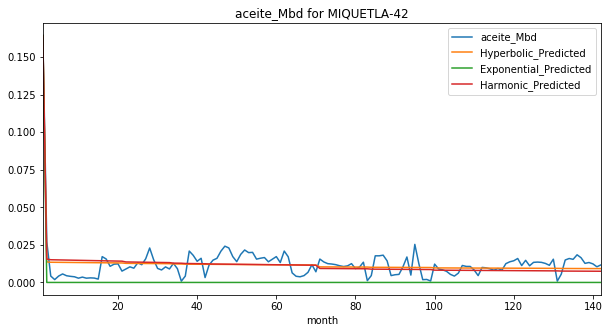

Exponential Fit Curve-fitted Variables: qi=0.18692568310546875, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.1869888203314135, b=1.9999999999999998, di=0.008621865909852151
Harmonic Fit Curve-fitted Variables: qi=0.1864964765294603, di=0.0010909356871287327


[['MIQUETLA-43', 0.18701700000000002]]

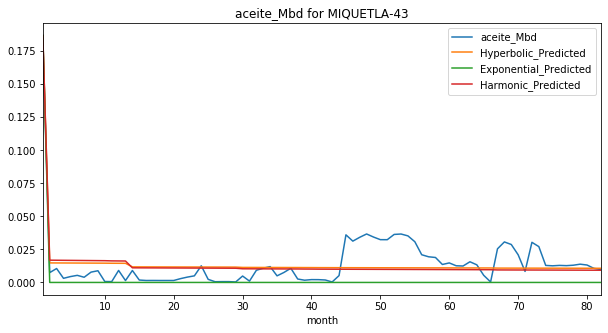

Exponential Fit Curve-fitted Variables: qi=0.14540596630859376, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.037098002125048, b=1.9999999999999998, di=0.00027745637736256425
Harmonic Fit Curve-fitted Variables: qi=0.03058359529828316, di=0.0001100182213637643


[['MIQUETLA-44', 0.145477]]

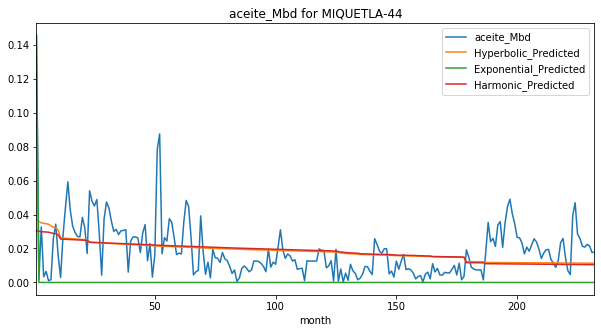

Exponential Fit Curve-fitted Variables: qi=0.19593628124999998, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.19603199999999496, b=0.5685052393588151, di=0.0006916933079222784
Harmonic Fit Curve-fitted Variables: qi=0.19603199999999996, di=0.0012021037264614604


[['MIQUETLA-45', 0.19603199999999998]]

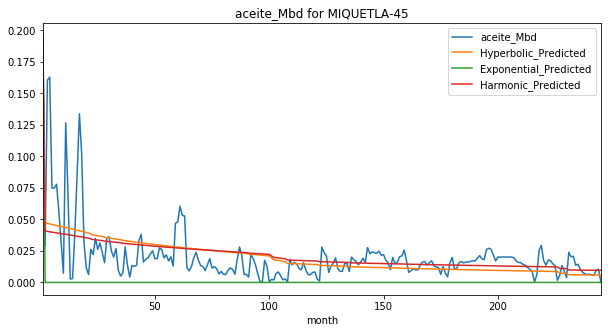

Exponential Fit Curve-fitted Variables: qi=0.17197198828125, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.1718252755739499, b=1.9999999999999998, di=0.01683311721114004
Harmonic Fit Curve-fitted Variables: qi=0.16517177695860927, di=0.0027626843092403014


[['MIQUETLA-46', 0.172056]]

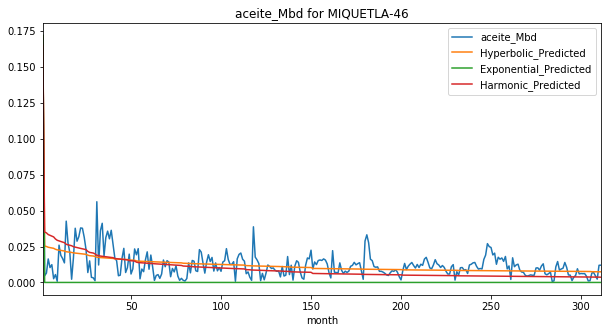

Exponential Fit Curve-fitted Variables: qi=0.18524499924535442, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2545099274020855, b=0.16196399806141223, di=0.00048326888080090944
Harmonic Fit Curve-fitted Variables: qi=0.24729838437012877, di=0.0011258392754609663


[['MIQUETLA-47', 0.339446]]

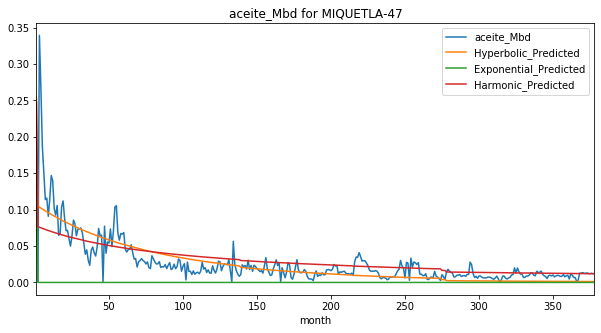

Exponential Fit Curve-fitted Variables: qi=0.2723464929199219, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.27241183891567416, b=1.571757711981836, di=0.965994945732968
Harmonic Fit Curve-fitted Variables: qi=0.27234649291990387, di=0.039393334668005396


[['MIQUETLA-48', 0.272413]]

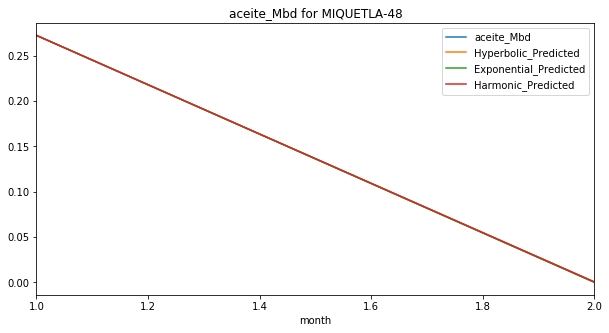

Exponential Fit Curve-fitted Variables: qi=0.2314484802246094, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2314484802246094, b=1.0, di=5.0
Harmonic Fit Curve-fitted Variables: qi=0.2314484802246094, di=5.0


[['MIQUETLA-49', 0.23150500000000002]]

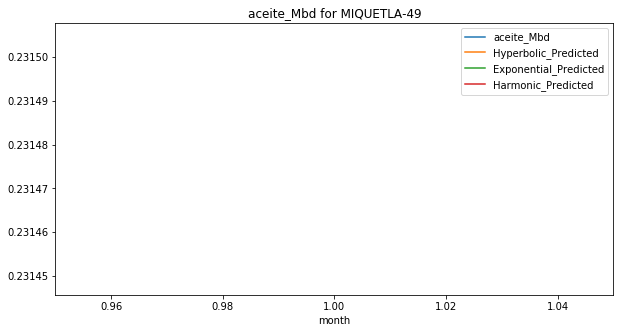

Exponential Fit Curve-fitted Variables: qi=0.21862161254882814, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.21867497991713644, b=0.23388952187448564, di=0.0003266675490964175
Harmonic Fit Curve-fitted Variables: qi=0.21862224965039612, di=0.0017088487170939823


[['MIQUETLA-50', 0.218675]]

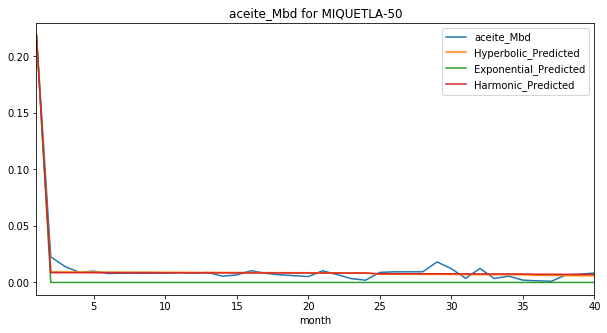

Exponential Fit Curve-fitted Variables: qi=0.177245412109375, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.17728821536026546, b=1.9382373108783342, di=0.02043031498787309
Harmonic Fit Curve-fitted Variables: qi=0.17564109892207724, di=0.0032776929920045558


[['MIQUETLA-51', 0.177332]]

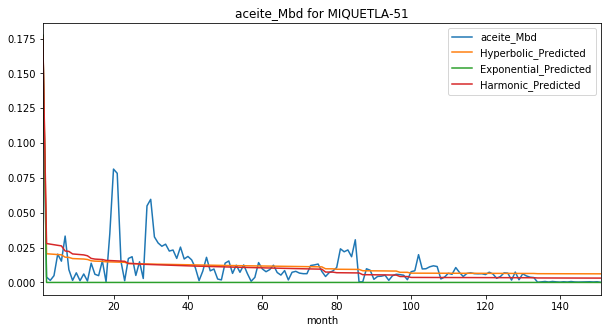

Exponential Fit Curve-fitted Variables: qi=0.1538148583984375, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.15286182516953384, b=1.9999999999999998, di=0.01075228798770823
Harmonic Fit Curve-fitted Variables: qi=0.1424903647372989, di=0.0023403205635337612


[['MIQUETLA-52', 0.15389]]

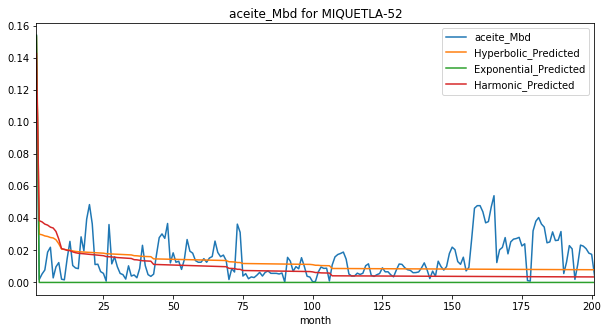

Exponential Fit Curve-fitted Variables: qi=0.17055268164062498, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.1685216888027118, b=1.9999999999999998, di=0.01770734350259328
Harmonic Fit Curve-fitted Variables: qi=0.15435290268880922, di=0.005018587380225915


[['MIQUETLA-54', 0.17063599999999998]]

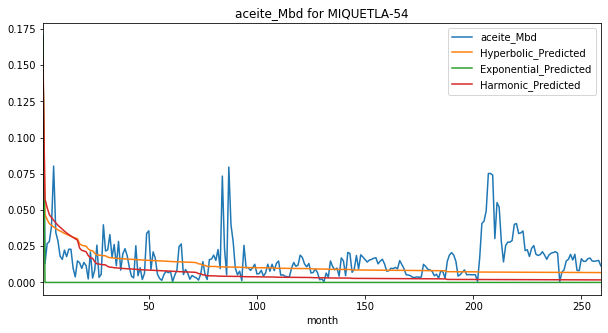

Exponential Fit Curve-fitted Variables: qi=0.15960203125, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.15960203125, b=1.0, di=5.0
Harmonic Fit Curve-fitted Variables: qi=0.15960203125, di=5.0


[['MIQUETLA-55', 0.15968]]

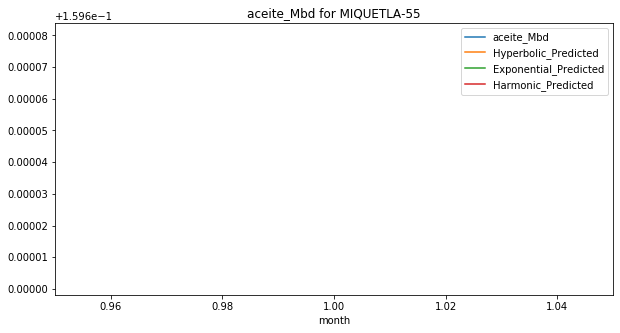

Exponential Fit Curve-fitted Variables: qi=0.12866814306640623, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.12866814306640623, b=1.0, di=5.0
Harmonic Fit Curve-fitted Variables: qi=0.12866814306640623, di=5.0


[['MIQUETLA-56', 0.12873099999999998]]

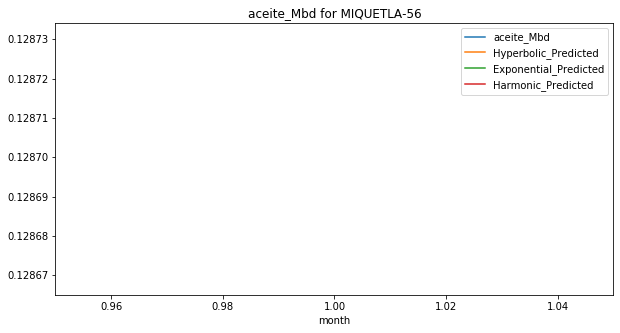

Exponential Fit Curve-fitted Variables: qi=0.012999220271209616, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.018443476218086768, b=1.9999999999999998, di=3.554888455005977e-05
Harmonic Fit Curve-fitted Variables: qi=0.01754475452620215, di=2.218385992277914e-05


[['MIQUETLA-92', 0.05234]]

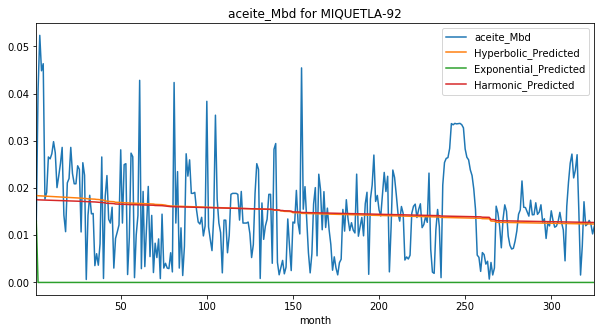

Exponential Fit Curve-fitted Variables: qi=0.2358104150390625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2358578008186989, b=1.9999999999999998, di=0.00960306219190911
Harmonic Fit Curve-fitted Variables: qi=0.235624120246093, di=0.0011709264927218653


[['MIQUETLA-58', 0.235868]]

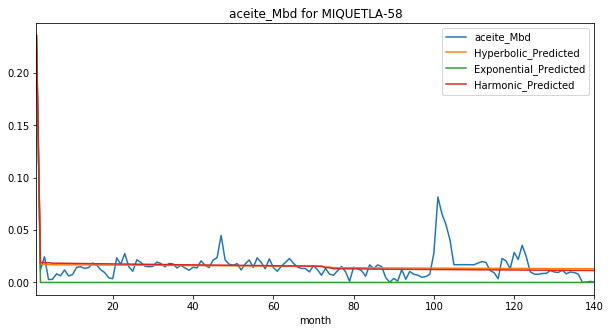

Exponential Fit Curve-fitted Variables: qi=0.24098215209960935, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.24098215209960935, b=1.0, di=5.0
Harmonic Fit Curve-fitted Variables: qi=0.24098215209960935, di=5.0


[['MIQUETLA-59', 0.24104099999999998]]

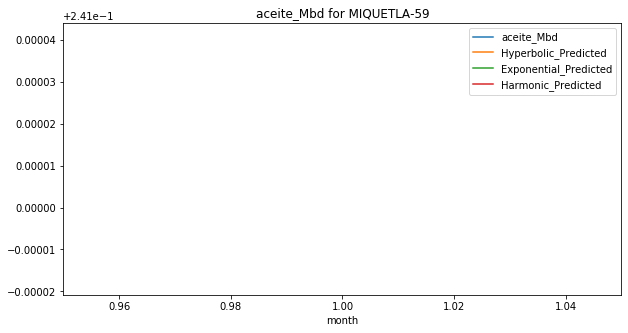

Exponential Fit Curve-fitted Variables: qi=0.0026381031891013844, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.059207350198296725, b=1.9999999999999998, di=0.0007276258562051679
Harmonic Fit Curve-fitted Variables: qi=0.042875043862755896, di=0.0001736206934067862


[['MIQUETLA-107', 0.135738]]

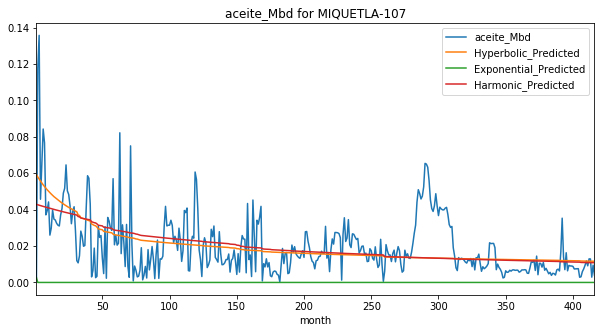

Exponential Fit Curve-fitted Variables: qi=0.12025925097656251, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.11943440946118636, b=1.9999999999999998, di=0.0018940431319280971
Harmonic Fit Curve-fitted Variables: qi=0.1127431040537999, di=0.0004635281773341895


[['MIQUETLA-60', 0.12031800000000001]]

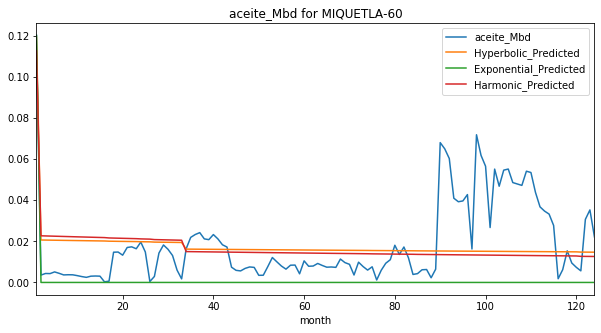

Exponential Fit Curve-fitted Variables: qi=0.020695000028722238, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.025806407492520687, b=1.6265936487247733e-08, di=5.1384116448866034e-05
Harmonic Fit Curve-fitted Variables: qi=0.026567039687784642, di=7.311283206579741e-05


[['MIQUETLA-95', 0.05744700000000001]]

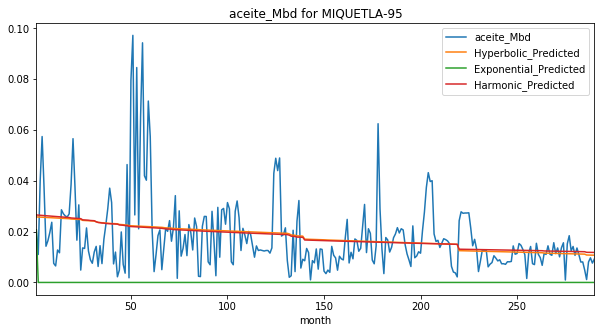

Exponential Fit Curve-fitted Variables: qi=0.11585540234375, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.11551163827019842, b=1.9999999999999998, di=0.07442877029423071
Harmonic Fit Curve-fitted Variables: qi=0.115720922031605, di=0.05822072198195203


[['MIQUETLA-61', 0.11591199999999999]]

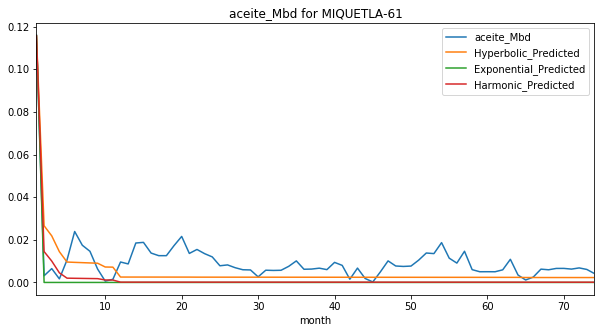

Exponential Fit Curve-fitted Variables: qi=0.1121472138671875, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.11183086280604701, b=1.9999999999999998, di=0.011954180476120261
Harmonic Fit Curve-fitted Variables: qi=0.10838606707731703, di=0.0023999313894582036


[['MIQUETLA-62', 0.112202]]

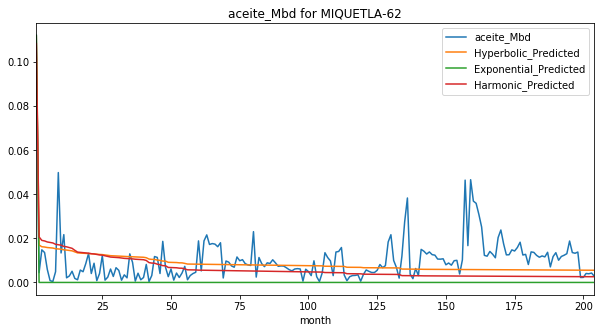

Exponential Fit Curve-fitted Variables: qi=0.13830843359375, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.1383687972969074, b=1.9999999999999998, di=0.00759468214181985
Harmonic Fit Curve-fitted Variables: qi=0.1382772266936722, di=0.0009660816149490218


[['MIQUETLA-63', 0.138376]]

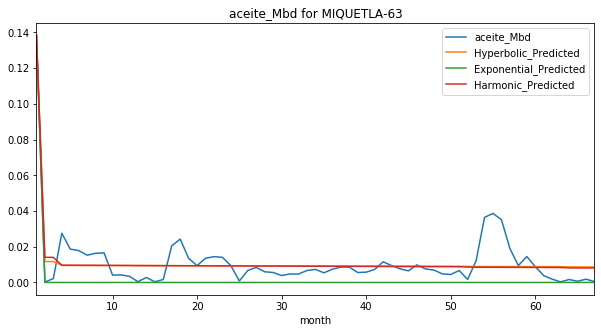

Exponential Fit Curve-fitted Variables: qi=0.1017954931640625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.10106698346602275, b=1.9999999999999998, di=0.022907657570185064
Harmonic Fit Curve-fitted Variables: qi=0.09309558047837264, di=0.005461843531593274


[['MIQUETLA-65', 0.101895]]

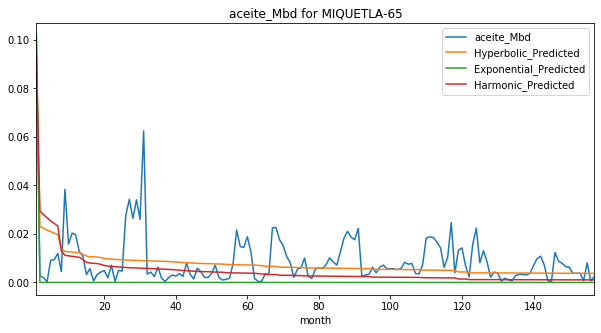

Exponential Fit Curve-fitted Variables: qi=0.080471337890625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.08020479764884476, b=0.11940672299807455, di=0.00021813271340470852
Harmonic Fit Curve-fitted Variables: qi=0.08054955711626896, di=0.0007512731367249901


[['MIQUETLA-66', 0.08055]]

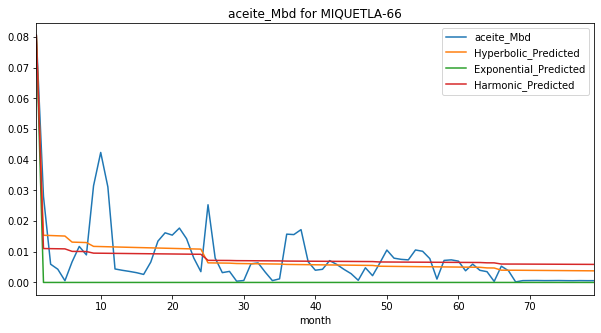

Exponential Fit Curve-fitted Variables: qi=0.0962818828125, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.0962818828125, b=1.0, di=5.0
Harmonic Fit Curve-fitted Variables: qi=0.0962818828125, di=5.0


[['MIQUETLA-67', 0.096376]]

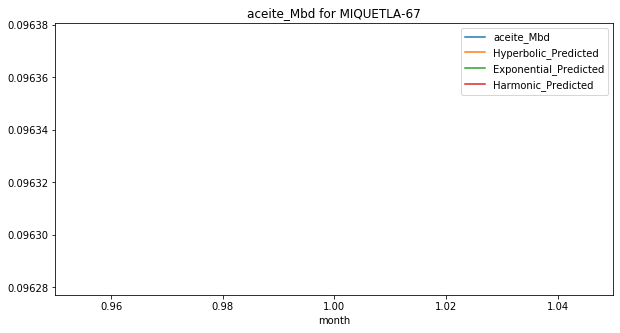

Exponential Fit Curve-fitted Variables: qi=0.103521427734375, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.10357131444934146, b=1.4171457736159454, di=0.0033990814834716746
Harmonic Fit Curve-fitted Variables: qi=0.10317496129235496, di=0.0017169795653946573


[['MIQUETLA-67A', 0.103572]]

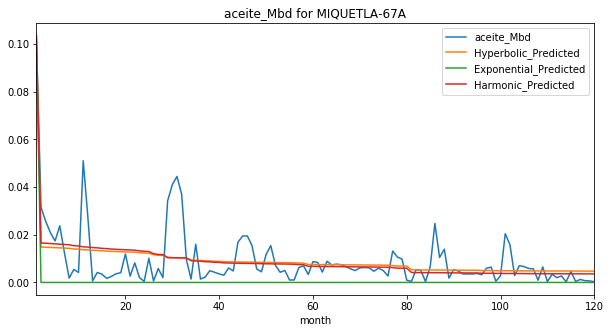

Exponential Fit Curve-fitted Variables: qi=0.1312099013671875, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.13120990136718752, b=1.0, di=5.0
Harmonic Fit Curve-fitted Variables: qi=0.1312099013671875, di=5.0


[['MIQUETLA-68', 0.131274]]

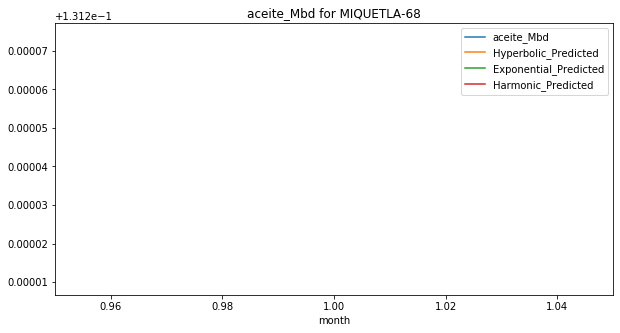

Exponential Fit Curve-fitted Variables: qi=0.18147734472656252, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.18156599999999998, b=0.6666819301142314, di=0.0008031420151267687
Harmonic Fit Curve-fitted Variables: qi=0.18156599999999962, di=0.001155769532499358


[['MIQUETLA-73', 0.181566]]

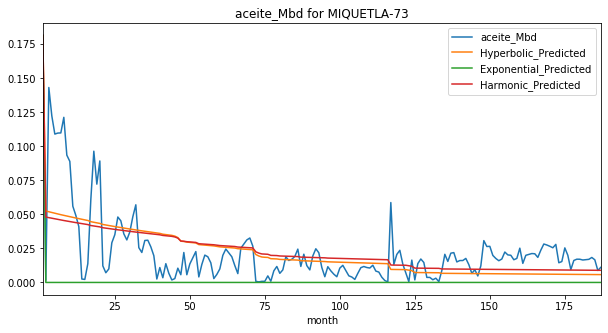

Exponential Fit Curve-fitted Variables: qi=0.12092599994968, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.11542181578569978, b=0.8288516663092937, di=0.0006799665879509304
Harmonic Fit Curve-fitted Variables: qi=0.1230790811549309, di=0.0008505033704422126


[['MIQUETLA-74', 0.15825899999999998]]

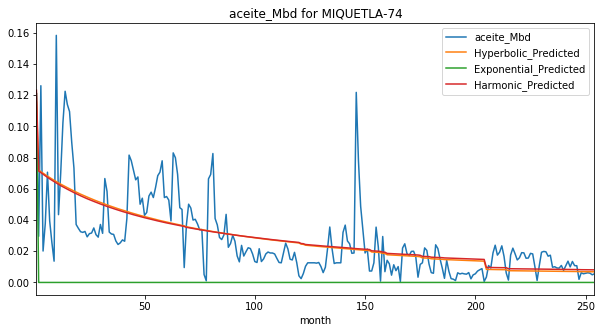

Exponential Fit Curve-fitted Variables: qi=0.11281071709055908, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.12194099999996832, b=1.2294331480165628, di=0.001420748830364048
Harmonic Fit Curve-fitted Variables: qi=0.1219409998677378, di=0.0011628643349684566


[['MIQUETLA-75', 0.12194100000000001]]

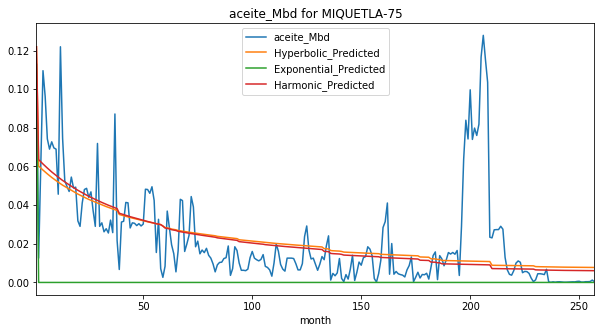

Exponential Fit Curve-fitted Variables: qi=0.0006757899484290296, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.08258611604681895, b=1.5689381768472475, di=0.0018205218691114671
Harmonic Fit Curve-fitted Variables: qi=0.07097931312595694, di=0.000853595551746038


[['MIQUETLA-112', 0.11699000000000001]]

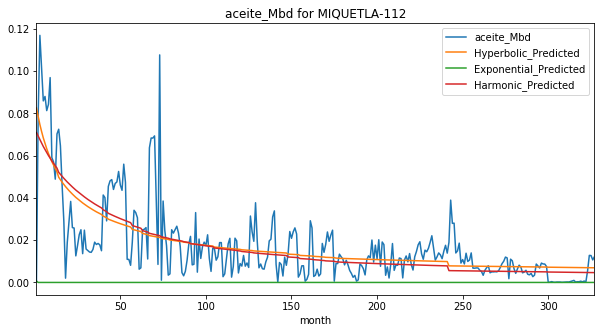

Exponential Fit Curve-fitted Variables: qi=0.05593399766933144, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.09627124319891256, b=1.4521088070433978e-11, di=0.0004054663514498392
Harmonic Fit Curve-fitted Variables: qi=0.10911145102691808, di=0.0009200032205354035


[['MIQUETLA-76', 0.11028099999999999]]

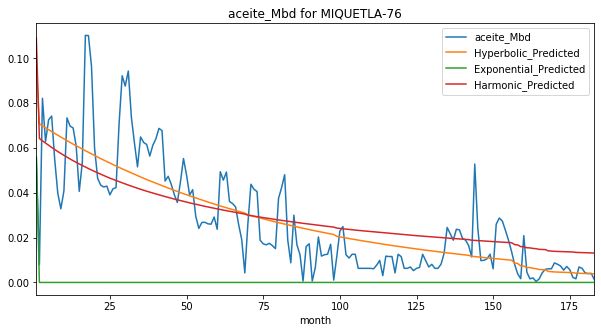

Exponential Fit Curve-fitted Variables: qi=0.191846279296875, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.14167936316898055, b=0.7003805888751501, di=0.0007958533108722884
Harmonic Fit Curve-fitted Variables: qi=0.16727856975710415, di=0.0013001153689739863


[['MIQUETLA-77', 0.19194]]

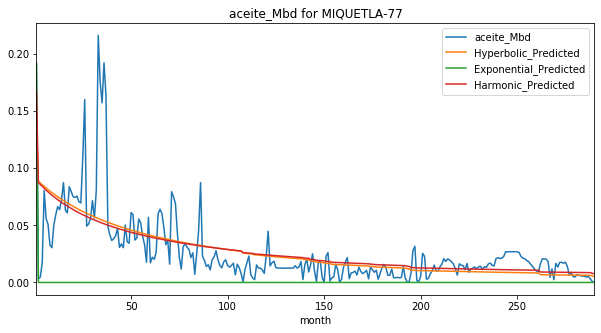

Exponential Fit Curve-fitted Variables: qi=0.1552821416015625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.15189242006651535, b=1.7337367936782575, di=0.004643897908216918
Harmonic Fit Curve-fitted Variables: qi=0.09750956189408656, di=0.0010321041464480946


[['MIQUETLA-78', 0.155358]]

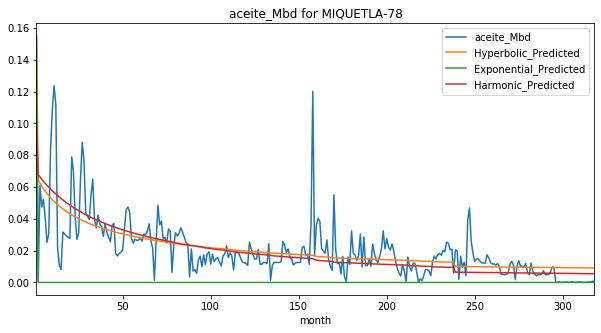

Exponential Fit Curve-fitted Variables: qi=0.14405698206331924, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.16071989846360535, b=0.691680398717292, di=0.0010561222685295081
Harmonic Fit Curve-fitted Variables: qi=0.16399089181130216, di=0.0014674665843806961


[['MIQUETLA-79', 0.17591199999999999]]

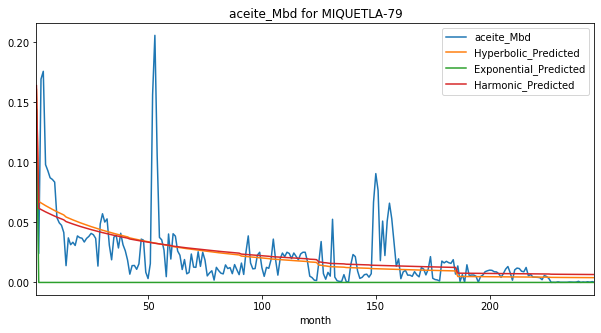

Exponential Fit Curve-fitted Variables: qi=0.11678100872911312, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.22838857219744735, b=3.059509951745157e-10, di=0.0005967193779924992
Harmonic Fit Curve-fitted Variables: qi=0.21222167780826326, di=0.0013040968915501326


[['MIQUETLA-80', 0.268027]]

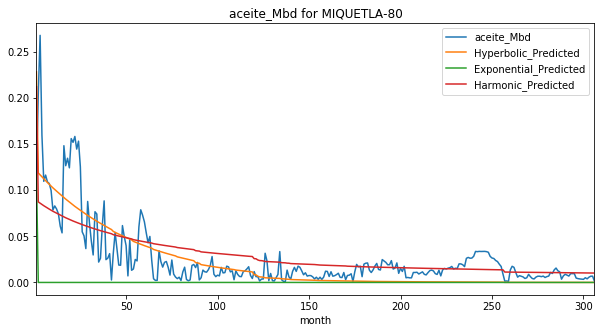

Exponential Fit Curve-fitted Variables: qi=0.0031450033605350996, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.03283956807717013, b=1.9741936963410127, di=0.00013749663607795046
Harmonic Fit Curve-fitted Variables: qi=0.030834844274508735, di=8.277814445019992e-05


[['MIQUETLA-85', 0.237389]]

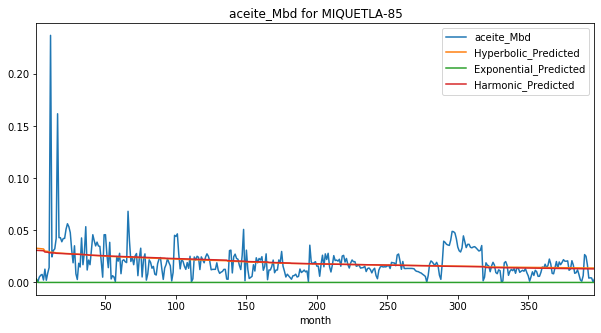

Exponential Fit Curve-fitted Variables: qi=0.11843414257812501, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.11849199999894655, b=1.3539565865605465, di=0.001519789323354548
Harmonic Fit Curve-fitted Variables: qi=0.11837823596509457, di=0.0010102073391684316


[['MIQUETLA-81', 0.11849200000000001]]

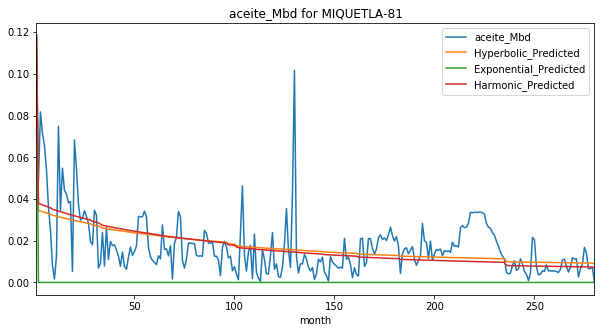

Exponential Fit Curve-fitted Variables: qi=0.0014252552389821176, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.027742787339965592, b=0.9831452328680611, di=0.0001223340472429638
Harmonic Fit Curve-fitted Variables: qi=0.02777479096991019, di=0.00012345940476115965


[['MIQUETLA-94', 0.131187]]

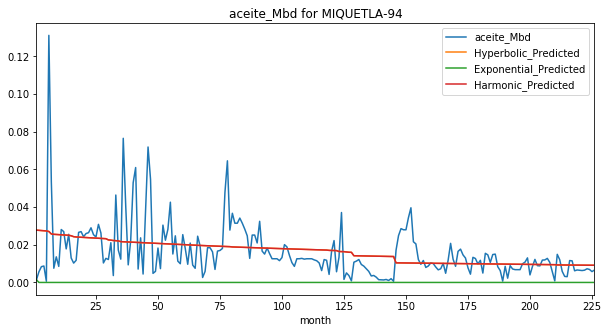

Exponential Fit Curve-fitted Variables: qi=0.0026414349118599433, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.012559780316095425, b=1.9999999999999998, di=8.434958692380601e-06
Harmonic Fit Curve-fitted Variables: qi=0.012278693985760899, di=5.333709216807265e-06


[['MIQUETLA-102', 0.104289]]

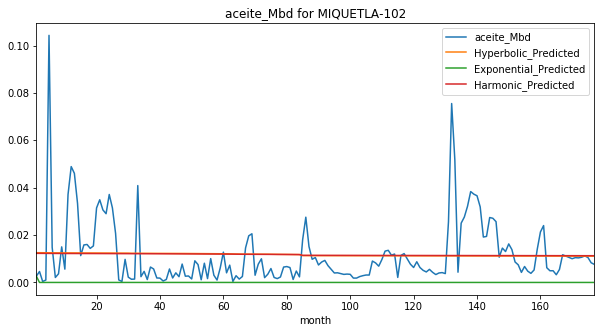

Exponential Fit Curve-fitted Variables: qi=0.07831799996004166, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.05348315505179174, b=0.8279864945457799, di=0.00022064807423763624
Harmonic Fit Curve-fitted Variables: qi=0.05437705862740843, di=0.00024876743816914414


[['MIQUETLA-82', 0.10226]]

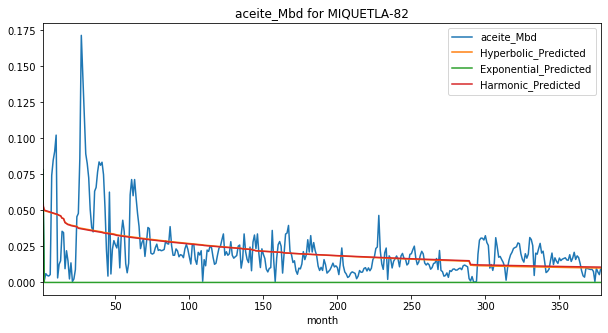

Exponential Fit Curve-fitted Variables: qi=0.0034495049765590267, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.020337315298761285, b=1.109312621981122, di=4.2744417680359926e-05
Harmonic Fit Curve-fitted Variables: qi=0.020297195973262572, di=4.152036606799523e-05


[['MIQUETLA-96', 0.028607999999999998]]

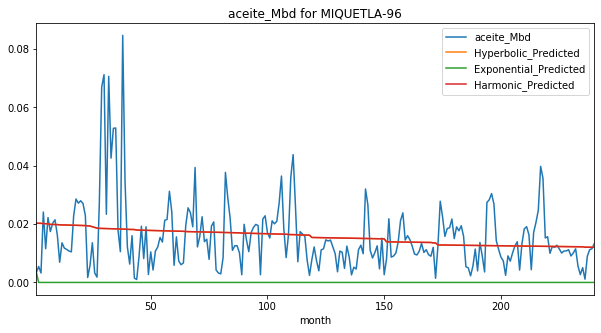

Exponential Fit Curve-fitted Variables: qi=0.14026298169251014, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.14730299981335382, b=1.1747494063228043, di=0.0011164919977205482
Harmonic Fit Curve-fitted Variables: qi=0.14647547285243695, di=0.0009141476068166388


[['MIQUETLA-83', 0.147303]]

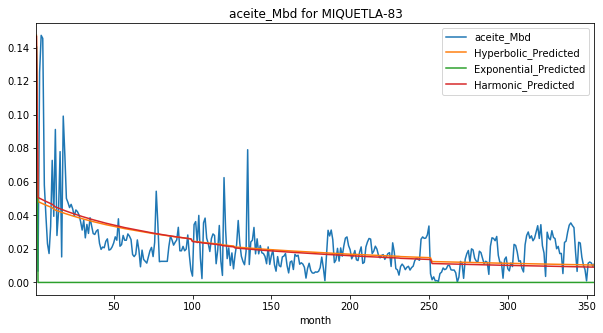

Exponential Fit Curve-fitted Variables: qi=0.125734576171875, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.12579517822329755, b=1.173572120411186, di=0.0024613569419440675
Harmonic Fit Curve-fitted Variables: qi=0.12436626643175482, di=0.0019670560789801167


[['MIQUETLA-84', 0.125796]]

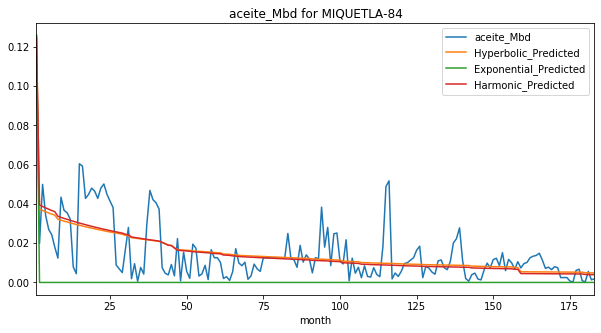

Exponential Fit Curve-fitted Variables: qi=0.1407412451171875, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.14045234297790304, b=1.9999999999999998, di=0.02109930137166657
Harmonic Fit Curve-fitted Variables: qi=0.13388966420249504, di=0.004090574420234493


[['MIQUETLA-91', 0.14081]]

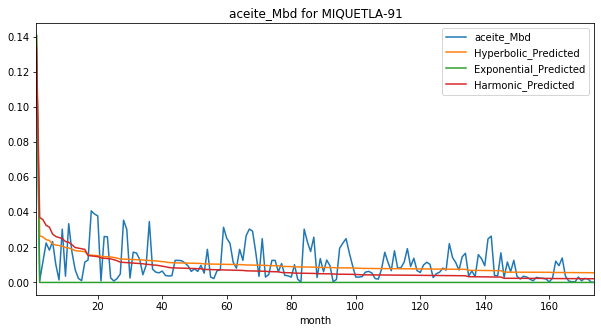

Exponential Fit Curve-fitted Variables: qi=0.010551531774336874, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.043796976891034504, b=1.0250938210875862, di=0.0005264061561196731
Harmonic Fit Curve-fitted Variables: qi=0.043677940769931194, di=0.0005157685495026644


[['MIQUETLA-108', 0.079333]]

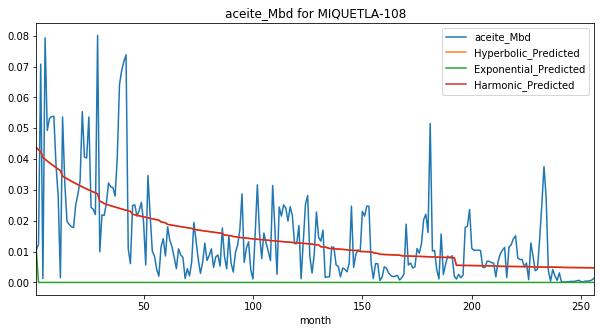

Exponential Fit Curve-fitted Variables: qi=0.11316071875000001, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.11316071875, b=1.0, di=5.0
Harmonic Fit Curve-fitted Variables: qi=0.11316071875000001, di=5.0


[['MIQUETLA-99', 0.11321600000000001]]

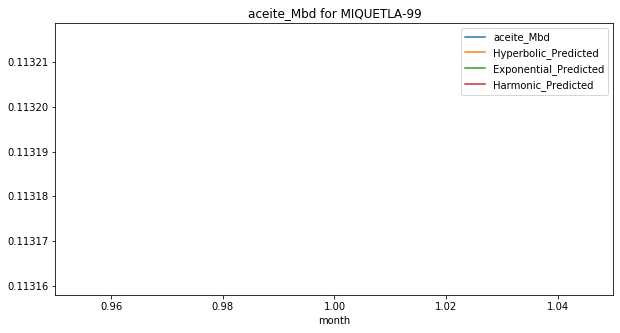

Exponential Fit Curve-fitted Variables: qi=0.1108558447265625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.10304021473206183, b=1.9999999999999993, di=0.0010477439108749187
Harmonic Fit Curve-fitted Variables: qi=0.022657089706567022, di=2.9626591379475654e-16


[['MIQUETLA-101', 0.11091]]

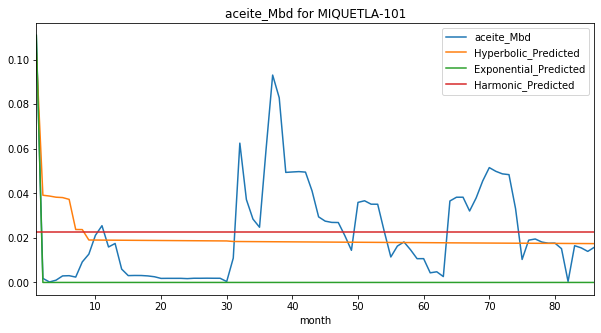

Exponential Fit Curve-fitted Variables: qi=0.0004134212630969173, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.024767170735873298, b=1.9999999999999998, di=0.00010319987894322856
Harmonic Fit Curve-fitted Variables: qi=0.023292063484671065, di=6.187701140894167e-05


[['MIQUETLA-113', 0.052114999999999995]]

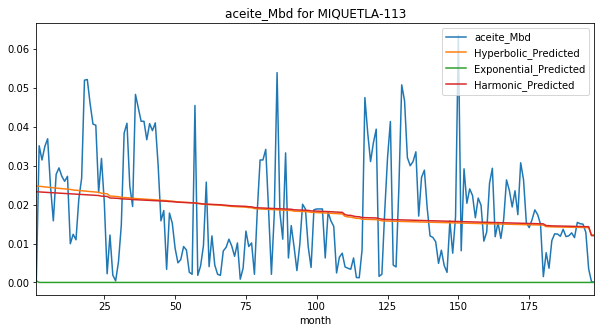

Exponential Fit Curve-fitted Variables: qi=0.0982019427756006, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.11779806126871088, b=2.0387266459267486e-10, di=0.00015161478568689803
Harmonic Fit Curve-fitted Variables: qi=0.12600165150422918, di=0.00038909325748964996


[['MIQUETLA-103', 0.137158]]

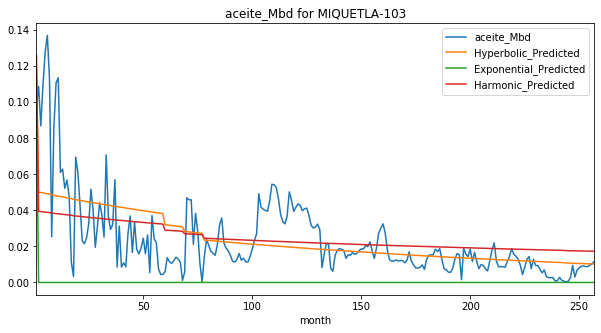

Exponential Fit Curve-fitted Variables: qi=0.08901898242187499, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.08846798902365108, b=0.8822788968367564, di=0.00036749949768362323
Harmonic Fit Curve-fitted Variables: qi=0.08895740220817555, di=0.00042009487186543746


[['MIQUETLA-104', 0.08910599999999999]]

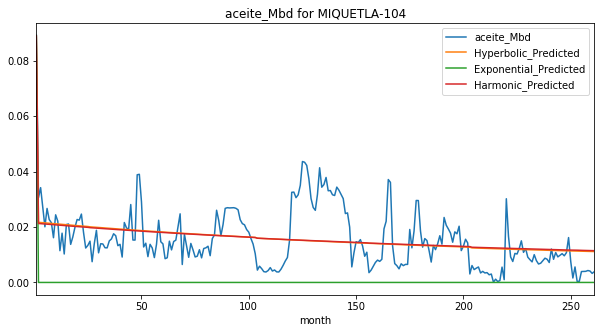

Exponential Fit Curve-fitted Variables: qi=0.09718785629041758, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.09728486360907933, b=1.3923071971154604, di=0.0011466308391674355
Harmonic Fit Curve-fitted Variables: qi=0.09676100797398633, di=0.0006624158894097534


[['MIQUETLA-105', 0.162487]]

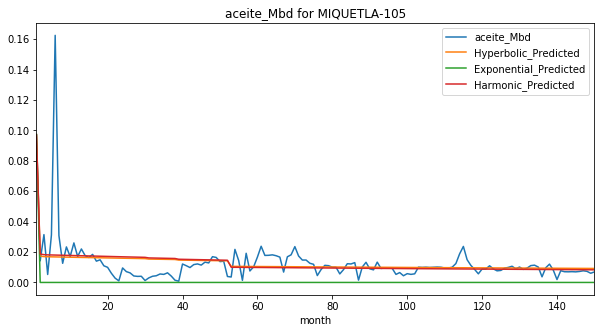

Exponential Fit Curve-fitted Variables: qi=0.08922777832031248, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.08912414269681482, b=1.9999999999999998, di=0.0017992447163756504
Harmonic Fit Curve-fitted Variables: qi=0.08581856395198785, di=0.0004897968291989188


[['MIQUETLA-106', 0.08931499999999999]]

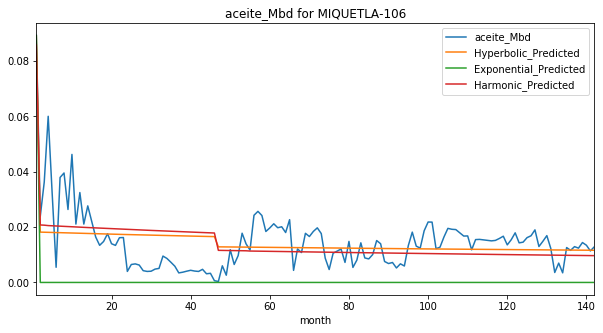

Exponential Fit Curve-fitted Variables: qi=0.0933877119140625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.09296427794217241, b=1.9999999999999998, di=0.0017742638717083527
Harmonic Fit Curve-fitted Variables: qi=0.08667565336207295, di=0.0004448543338672602


[['MIQUETLA-109', 0.09347899999999999]]

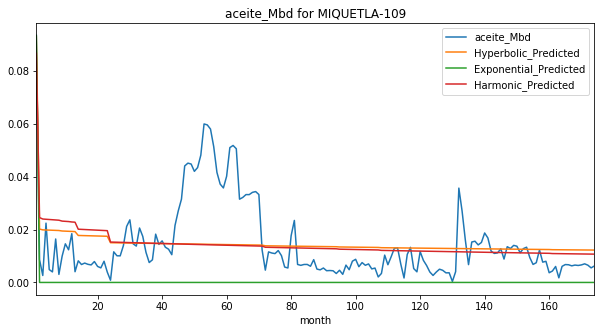

Exponential Fit Curve-fitted Variables: qi=0.0778359140625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.07791191866925937, b=1.6238282468772787e-09, di=0.00016031391569897163
Harmonic Fit Curve-fitted Variables: qi=0.07784294559668366, di=0.000671713500621827


[['MIQUETLA-110', 0.077912]]

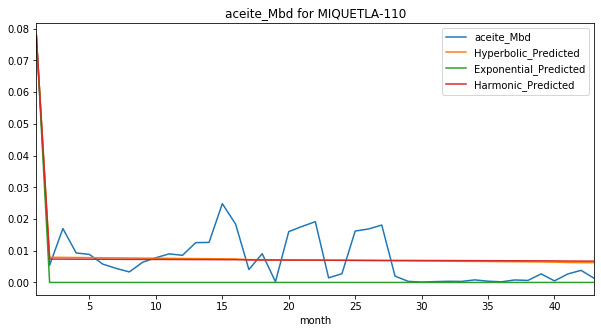

Exponential Fit Curve-fitted Variables: qi=0.09048454980468751, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.08489798990396413, b=1.9999999999999998, di=0.006018218760534672
Harmonic Fit Curve-fitted Variables: qi=0.017008360648062076, di=4.755560313450777e-05


[['MIQUETLA-111', 0.090573]]

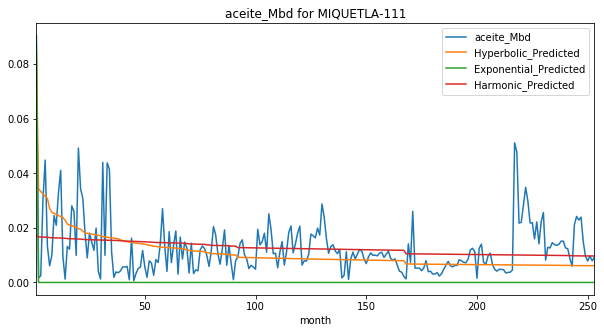

Exponential Fit Curve-fitted Variables: qi=0.0012605422192825608, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.036687325208802045, b=1.942593232550467, di=0.00040681913320369747
Harmonic Fit Curve-fitted Variables: qi=0.03353143773167592, di=0.00019538300937930396


[['MIQUETLA-124', 0.053159000000000005]]

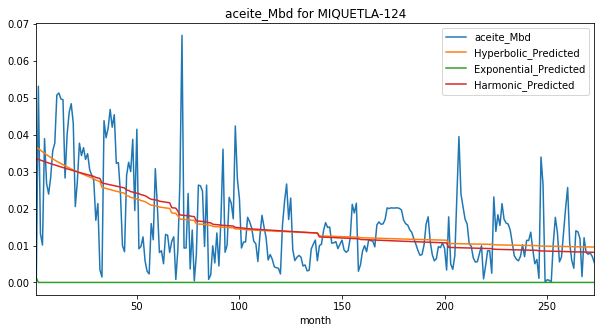

Exponential Fit Curve-fitted Variables: qi=0.02941950837394641, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.023738269274194212, b=1.9999999999999998, di=0.000431973218093818
Harmonic Fit Curve-fitted Variables: qi=0.01730766212890463, di=0.00012039777037577528


[['MIQUETLA-114', 0.038145]]

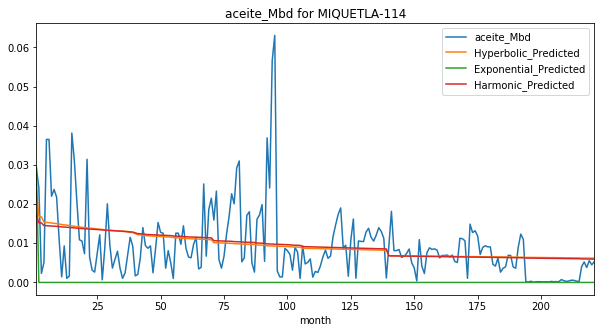

Exponential Fit Curve-fitted Variables: qi=0.02546513671875, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.025564999999027, b=2.68468881692314e-08, di=8.06656213241587e-05
Harmonic Fit Curve-fitted Variables: qi=0.025530980753057545, di=0.00015967627337532003


[['MIQUETLA-115', 0.025565]]

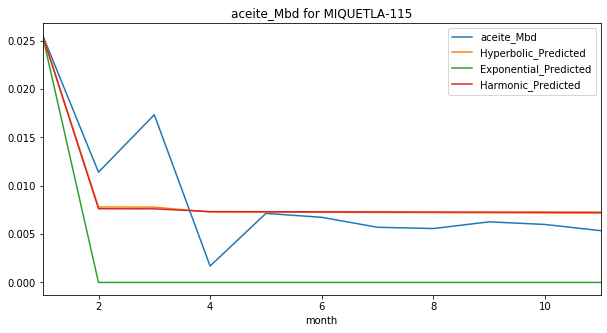

Exponential Fit Curve-fitted Variables: qi=0.015725003294384424, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.0182297374020869, b=3.4880507394243854e-07, di=2.639069597382598e-05
Harmonic Fit Curve-fitted Variables: qi=0.018443384709861163, di=3.238286497293368e-05


[['MIQUETLA-116', 0.050927]]

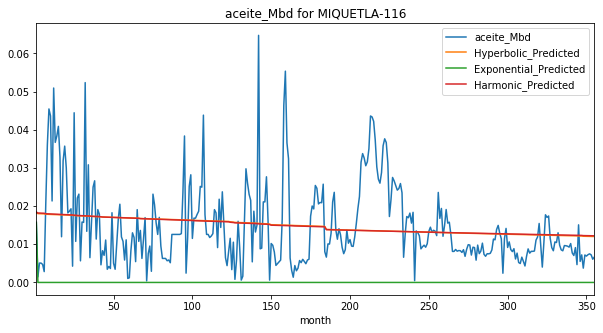

Exponential Fit Curve-fitted Variables: qi=0.0010155082956002696, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.017808418398911292, b=1.9999999998890607, di=0.000203545958949841
Harmonic Fit Curve-fitted Variables: qi=0.015441060168178462, di=9.009295750134184e-05


[['MIQUETLA-117', 0.040884]]

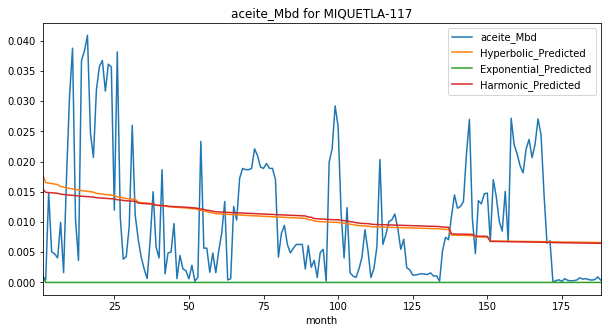

Exponential Fit Curve-fitted Variables: qi=0.08420069238281251, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.021327251869951273, b=7.142019787950704e-06, di=4.670137377645021e-19
Harmonic Fit Curve-fitted Variables: qi=0.02132725181875362, di=1.3377865856742211e-17


[['MIQUETLA-118', 0.08428300000000001]]

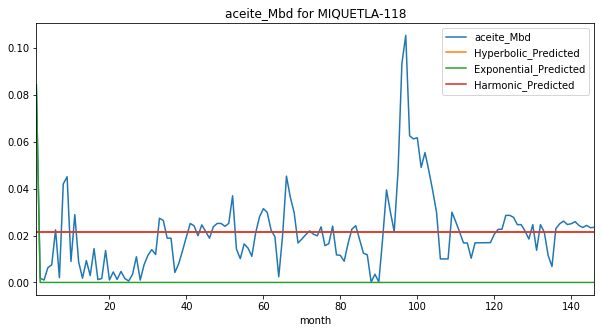

Exponential Fit Curve-fitted Variables: qi=0.05736392578125001, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.05741666819772399, b=1.991893422343041, di=0.004534645576386363
Harmonic Fit Curve-fitted Variables: qi=0.0572711181897769, di=0.0008301690939314635


[['MIQUETLA-121', 0.05742000000000001]]

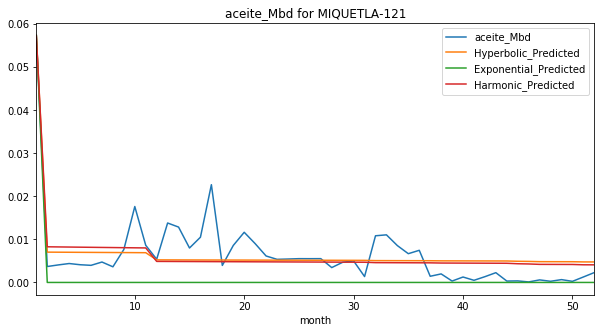

Exponential Fit Curve-fitted Variables: qi=0.036854876953125004, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.036854876953125004, b=1.0, di=5.0
Harmonic Fit Curve-fitted Variables: qi=0.036854876953125004, di=5.0


[['MIQUETLA-125', 0.036927]]

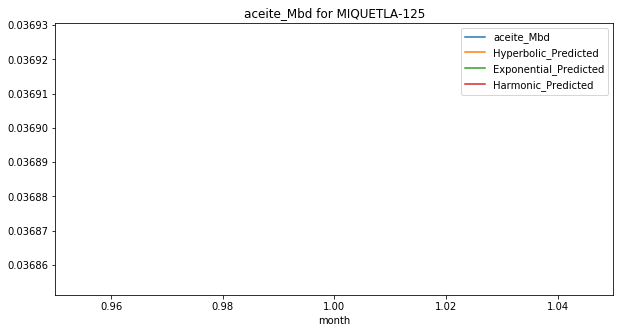

Exponential Fit Curve-fitted Variables: qi=0.033689072265625, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.02847168886801988, b=4.0573566502440813e-07, di=7.227277943962233e-05
Harmonic Fit Curve-fitted Variables: qi=0.03164311223645518, di=0.00013444440105028795


[['MIQUETLA-126', 0.033755]]

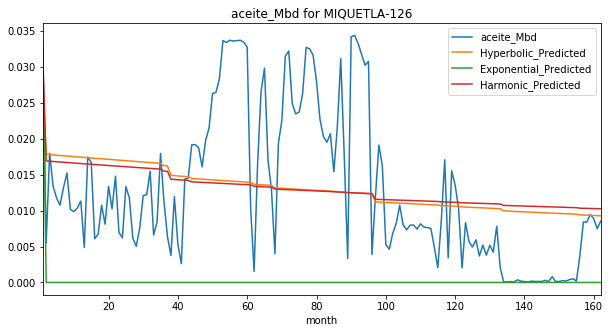

Exponential Fit Curve-fitted Variables: qi=0.034829839843749995, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.03482983984375, b=1.0, di=5.0
Harmonic Fit Curve-fitted Variables: qi=0.034829839843749995, di=5.0


[['MIQUETLA-127', 0.034898]]

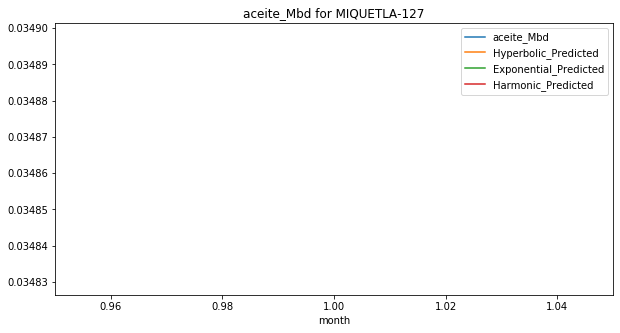

Exponential Fit Curve-fitted Variables: qi=0.00013787890955146946, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.005385655229963922, b=4.294157451554788e-09, di=7.184968936258866e-06
Harmonic Fit Curve-fitted Variables: qi=0.0053864436443374995, di=7.398916299842591e-06


[['MIQUETLA-1', 0.012218000000000001]]

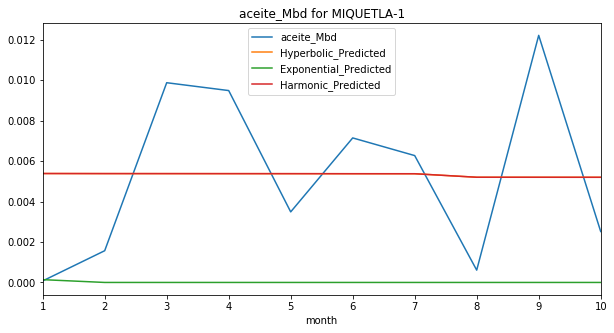

Exponential Fit Curve-fitted Variables: qi=0.014456000230236339, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.04595595408497421, b=1.8463337023476636, di=0.0016941990622514772
Harmonic Fit Curve-fitted Variables: qi=0.042182978094783545, di=0.0009006981410584182


[['MIQUETLA-677', 0.067328]]

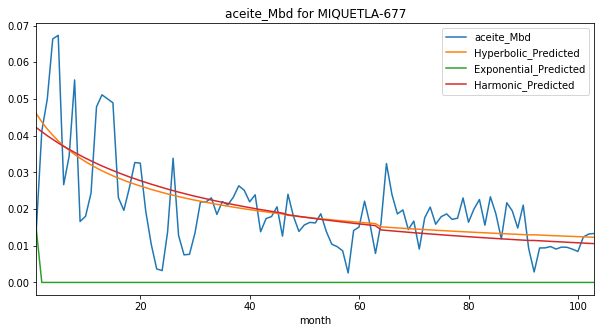

Exponential Fit Curve-fitted Variables: qi=0.014388001726582967, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.016407592396427386, b=4.92207828705493e-09, di=0.00010671634562748139
Harmonic Fit Curve-fitted Variables: qi=0.016216057027976512, di=0.00010567032176186084


[['MIQUETLA-356', 0.033322000000000004]]

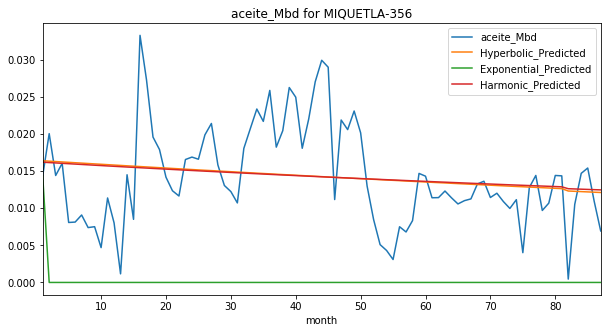

Exponential Fit Curve-fitted Variables: qi=0.02350497955759802, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.019259659371034004, b=1.9999999999999998, di=0.0004291441869613077
Harmonic Fit Curve-fitted Variables: qi=0.01700953098832079, di=0.0001927082543587537


[['MIQUETLA-3371', 0.032562]]

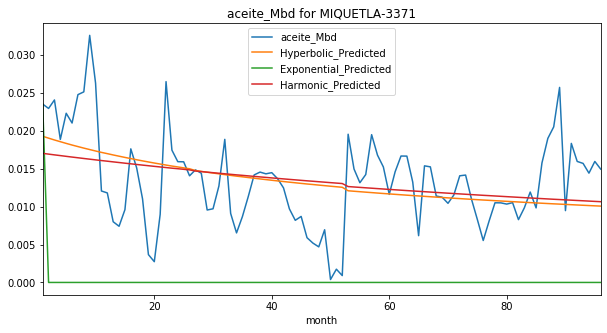

Exponential Fit Curve-fitted Variables: qi=0.022815527343750003, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.018570612336733235, b=1.9999999999999998, di=0.005709631636648979
Harmonic Fit Curve-fitted Variables: qi=0.011277495290869265, di=0.0007676927218989001


[['MIQUETLA-744', 0.022905000000000002]]

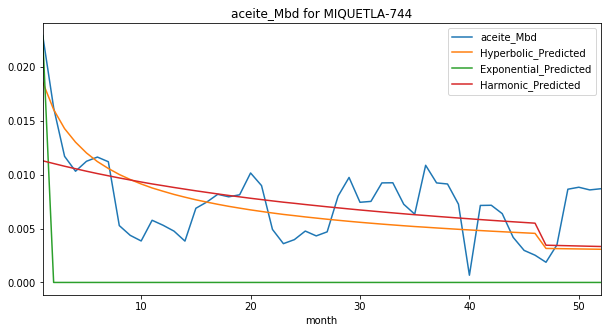

Exponential Fit Curve-fitted Variables: qi=0.017018010482601393, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.02515025928682477, b=1.9999999999999998, di=0.0013632567161242716
Harmonic Fit Curve-fitted Variables: qi=0.02201316100543622, di=0.000617563027658816


[['MIQUETLA-3134', 0.035017]]

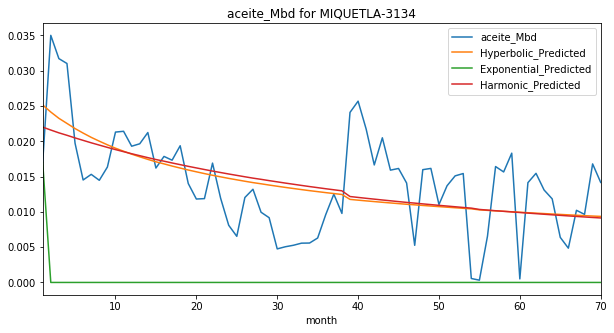

Exponential Fit Curve-fitted Variables: qi=0.013636382008802914, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.2456081200893266, b=8.8587838852358e-15, di=0.0004870369875223199
Harmonic Fit Curve-fitted Variables: qi=0.23378836481921045, di=0.0005114849701057033


[['MIQUETLA-829', 0.346826]]

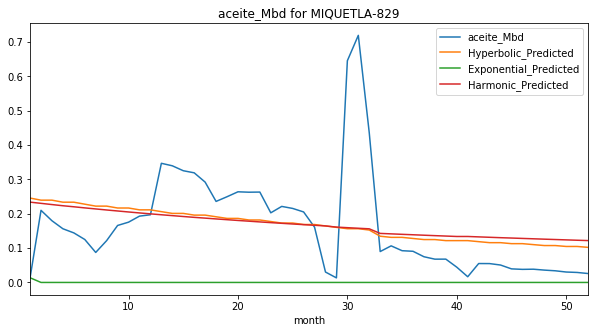

Exponential Fit Curve-fitted Variables: qi=0.021469003330266242, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.08314381378925458, b=0.8456255740556341, di=0.0018001170548444842
Harmonic Fit Curve-fitted Variables: qi=0.08393824502641947, di=0.0019837565441541225


[['MIQUETLA-553', 0.110849]]

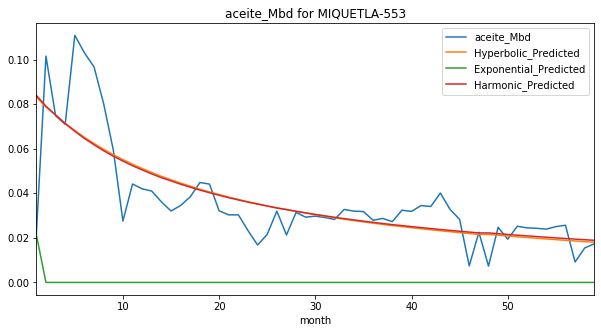

Exponential Fit Curve-fitted Variables: qi=0.03212909229981256, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.04039591008077088, b=1.2241102497167418, di=0.0013375003851273154
Harmonic Fit Curve-fitted Variables: qi=0.04008899369610327, di=0.0012067152818956792


[['MIQUETLA-502', 0.08061499999999999]]

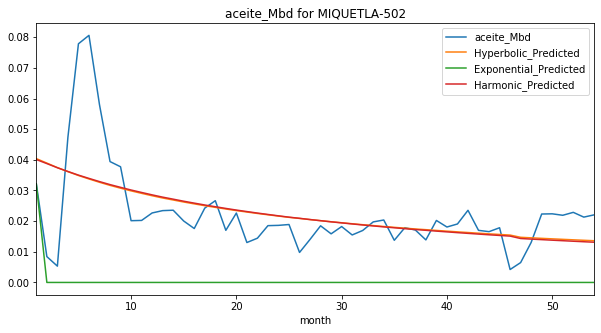

Exponential Fit Curve-fitted Variables: qi=0.015947480033472263, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.02645486485911736, b=0.5057003436277555, di=0.001309657733046274
Harmonic Fit Curve-fitted Variables: qi=0.0271697130895166, di=0.0017392018503851877


[['MIQUETLA-815', 0.04382]]

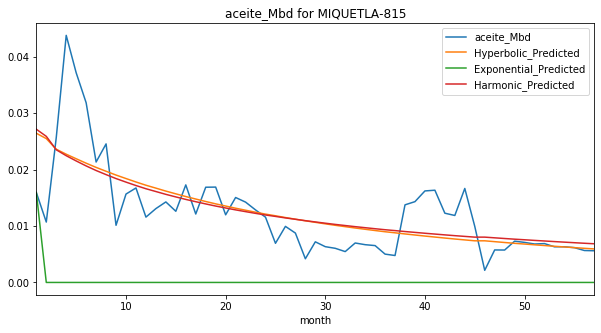

Exponential Fit Curve-fitted Variables: qi=0.015421000062730127, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.06702726800875017, b=0.24573601662588399, di=0.002688203949592945
Harmonic Fit Curve-fitted Variables: qi=0.06760336888558027, di=0.0044424195051664265


[['MIQUETLA-852', 0.11836300000000001]]

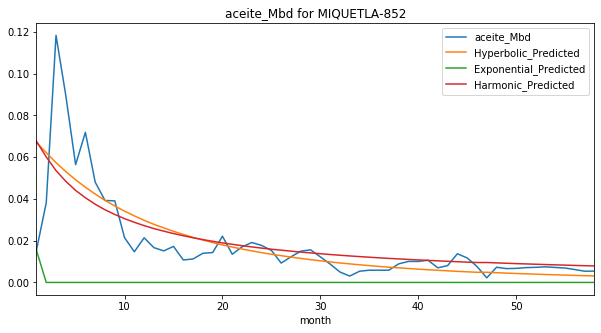

Exponential Fit Curve-fitted Variables: qi=0.0096810002479425, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.20003652568992247, b=1.5705140665104993e-08, di=0.0005385022306675325
Harmonic Fit Curve-fitted Variables: qi=0.19463426116981694, di=0.000610988169375517


[['MIQUETLA-1606', 0.293349837]]

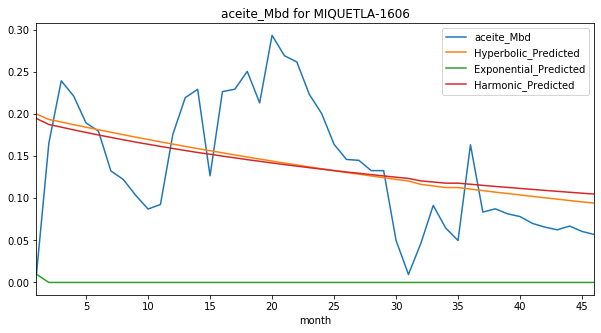

Exponential Fit Curve-fitted Variables: qi=0.03670000289066892, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.10119783940414696, b=1.558703528115196e-12, di=0.0004257157342284725
Harmonic Fit Curve-fitted Variables: qi=0.09906030452516443, di=0.0004641232839003082


[['MIQUETLA-847', 0.183410778]]

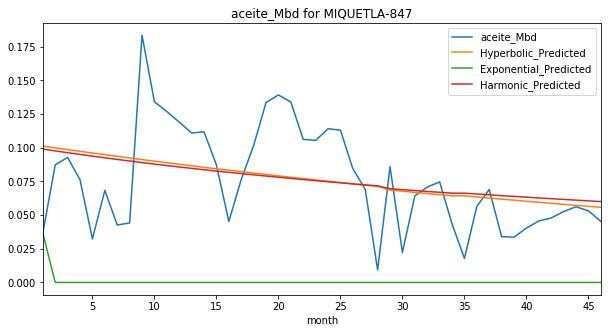

Exponential Fit Curve-fitted Variables: qi=0.0025055895312499996, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.0025737263246086626, b=1.9999999999514504, di=0.13856434092097394
Harmonic Fit Curve-fitted Variables: qi=0.002536024761097141, di=0.033656735289775704


[['MIQUETLA-10', 0.002586415]]

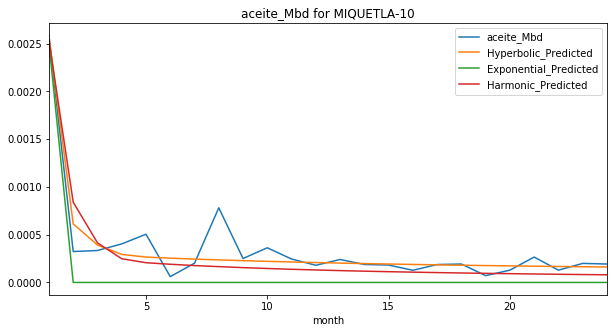

Exponential Fit Curve-fitted Variables: qi=0.011191108643704237, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.030013405073684184, b=0.5035341404319095, di=0.0010513721010380445
Harmonic Fit Curve-fitted Variables: qi=0.030745842897957884, di=0.00133489759833009


[['MIQUETLA-805', 0.046790742999999996]]

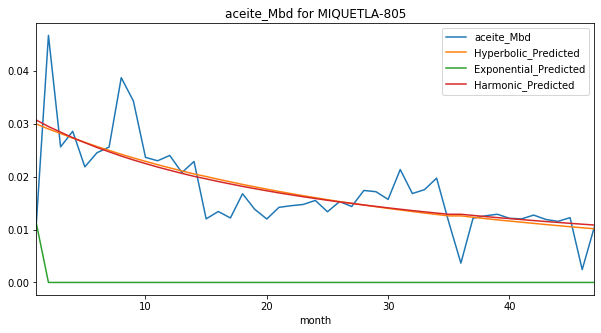

Exponential Fit Curve-fitted Variables: qi=0.10550211398196883, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.09744875612899746, b=7.507107181986086e-08, di=0.00048229485055374145
Harmonic Fit Curve-fitted Variables: qi=0.09770426800538594, di=0.0005939313558284164


[['MIQUETLA-1616', 0.107589821]]

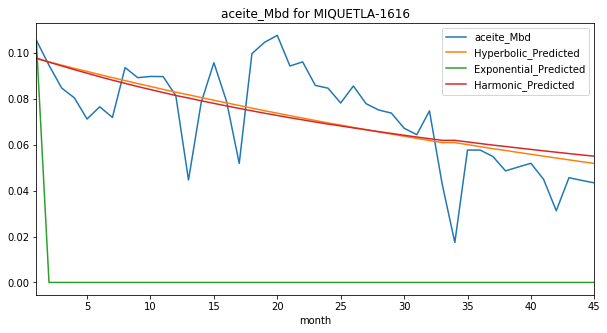

Exponential Fit Curve-fitted Variables: qi=0.09934813995822685, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.07397046548861619, b=1.9999999999999998, di=9.443435542427917e-05
Harmonic Fit Curve-fitted Variables: qi=0.07387863657145566, di=8.88034090520773e-05


[['MIQUETLA-1608', 0.130004187]]

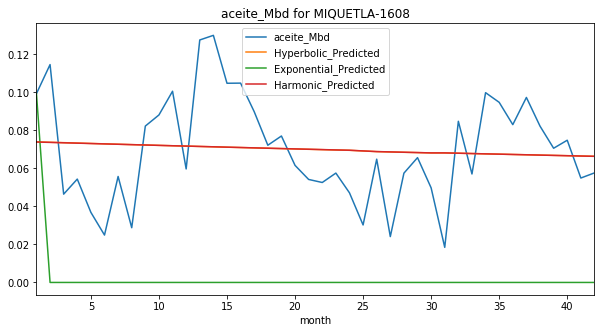

Exponential Fit Curve-fitted Variables: qi=0.0032611424050579263, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.014989064437833648, b=1.9999999990694224, di=0.002746725072841215
Harmonic Fit Curve-fitted Variables: qi=0.013570397465803335, di=0.0013800144308971508


[['MIQUETLA-833', 0.030093718]]

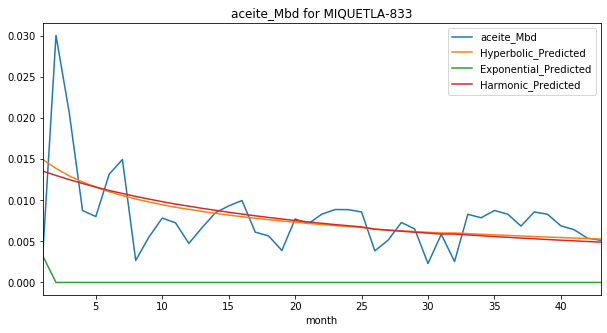

Exponential Fit Curve-fitted Variables: qi=0.026605512417968748, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.02665707091182254, b=1.1279375516951449, di=1.7414830897862679
Harmonic Fit Curve-fitted Variables: qi=0.026605512626990784, di=1.0684389502711482


[['MIQUETLA-1044', 0.026657577999999998]]

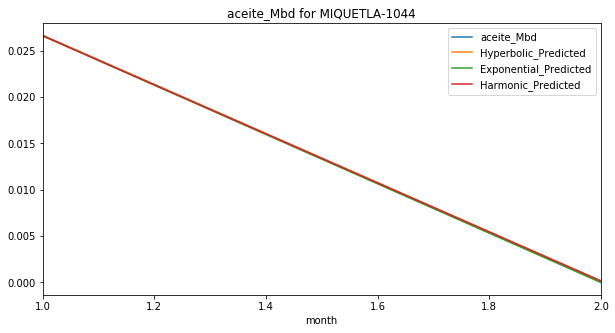

Exponential Fit Curve-fitted Variables: qi=0.051453088752264745, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.0893434549373154, b=8.264749847004093e-08, di=0.002970739714640365
Harmonic Fit Curve-fitted Variables: qi=0.09185567239256907, di=0.005518858146883985


[['MIQUETLA-3275', 0.094113005]]

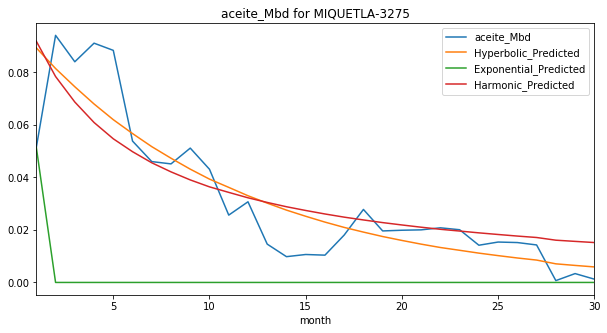

Exponential Fit Curve-fitted Variables: qi=0.059885297225776395, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.10210973830409911, b=1.0168151428777085e-14, di=0.0015018428292859305
Harmonic Fit Curve-fitted Variables: qi=0.10323060663007715, di=0.002017779569150137


[['MIQUETLA-849DES', 0.140881722]]

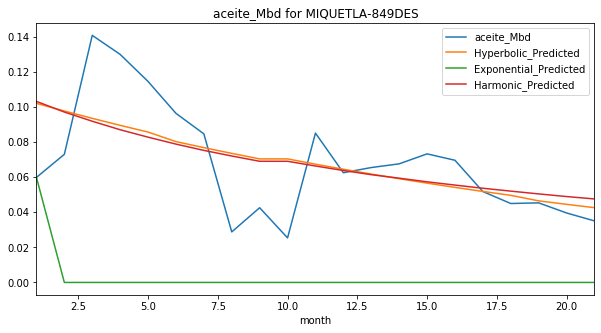

Exponential Fit Curve-fitted Variables: qi=0.1291919195620656, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.09497198449982844, b=1.9999999352279005, di=0.00012986062138337168
Harmonic Fit Curve-fitted Variables: qi=0.09490716880105533, di=0.00012426604339490049


[['MIQUETLA-1604DES', 0.22043256]]

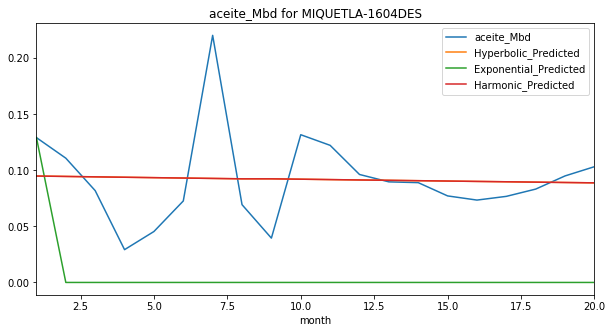

Exponential Fit Curve-fitted Variables: qi=0.030627048016707258, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.07265904906347055, b=1.1236379261231846e-10, di=0.001863223918027059
Harmonic Fit Curve-fitted Variables: qi=0.07297828051369208, di=0.0024629567353063593


[['MIQUETLA-827DES', 0.09292945400000001]]

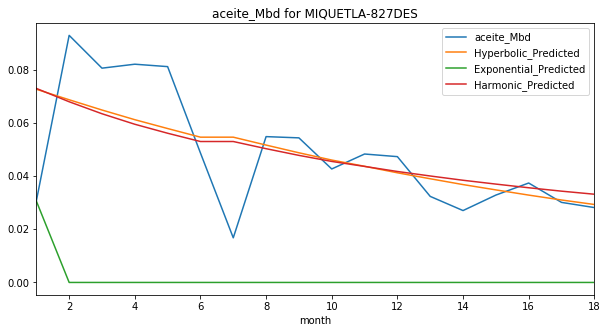

Exponential Fit Curve-fitted Variables: qi=0.006645377876637899, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.044516684848462634, b=1.999997630934618, di=5.763636750369752e-12
Harmonic Fit Curve-fitted Variables: qi=0.044516588414833996, di=1.3475960179744727e-11


[['MIQUETLA-865DES', 0.098910576]]

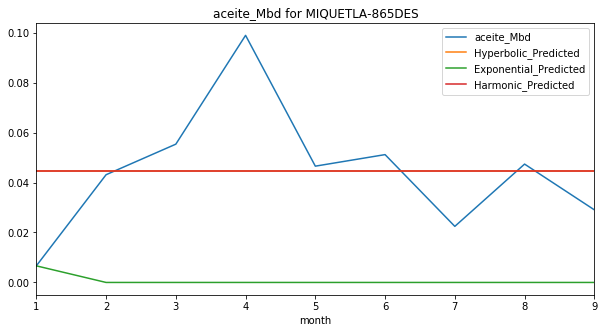

Exponential Fit Curve-fitted Variables: qi=0.02970271231749244, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.03993444722538132, b=0.10480793212224114, di=0.0029718137441817846
Harmonic Fit Curve-fitted Variables: qi=0.041387365501431975, di=0.00451480767463916


[['MIQUETLA-1618DES', 0.047583357]]

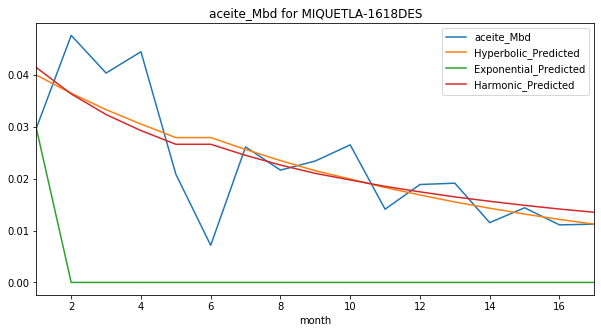

Exponential Fit Curve-fitted Variables: qi=0.03186036723372589, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.041999312062128306, b=1.8526225488478305, di=0.002902823415164392
Harmonic Fit Curve-fitted Variables: qi=0.041124910140849125, di=0.00217027912137514


[['MIQUETLA-1636DES', 0.050661202]]

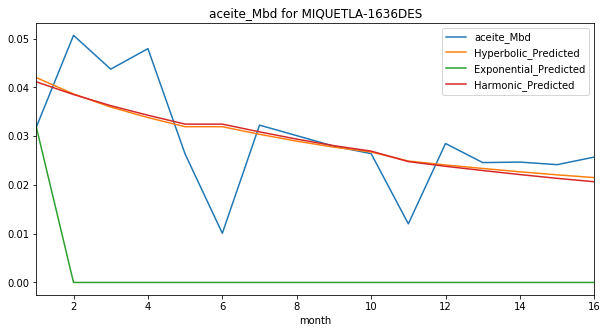

Exponential Fit Curve-fitted Variables: qi=0.001271065751335191, di=5.0
Hyperbolic Fit Curve-fitted Variables: qi=0.03174733037563964, b=4.907927991194522e-10, di=0.002539883385061286
Harmonic Fit Curve-fitted Variables: qi=0.030868466833532775, di=0.003121101304316461


[['MIQUETLA-1614DES', 0.053639445]]

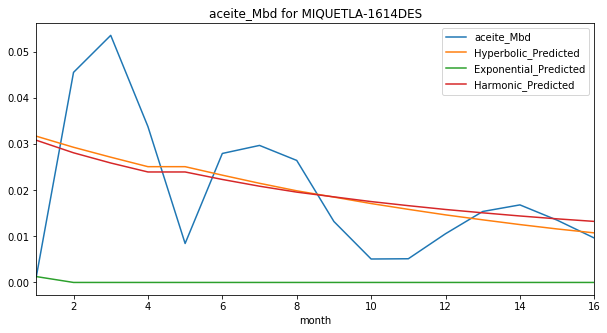

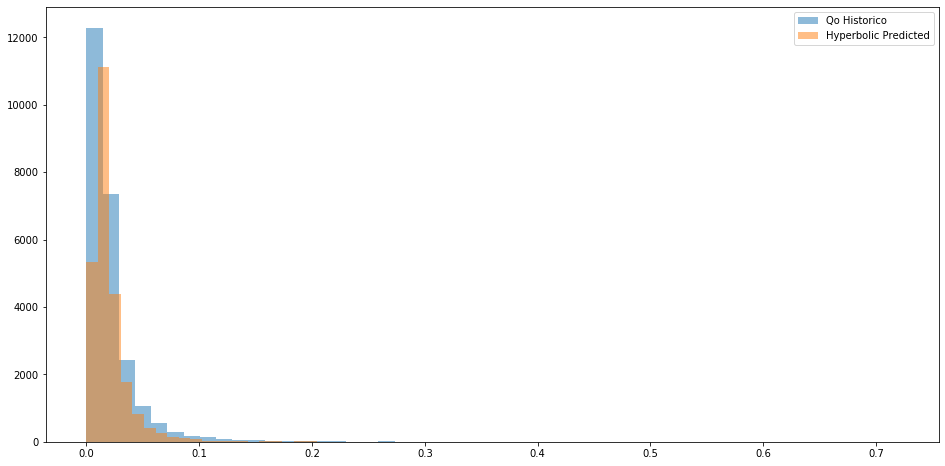

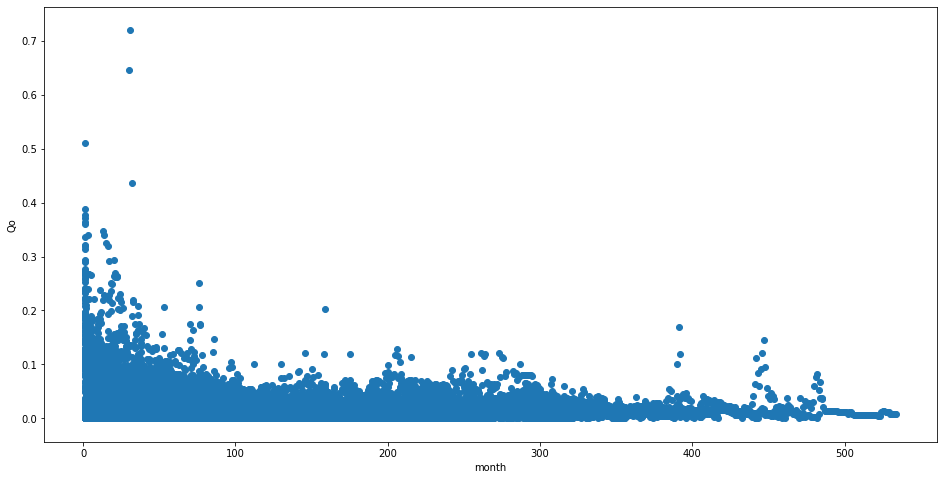

'Tiempo de procesamiento: 364.48867619999965 segundos'

In [45]:
productividad()

In [ ]:
periodo=np.arange(start=1,stop=201,step=1)
fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=200,normalize=True,closed='left')

df=pd.DataFrame()

df['date']=fechas
df['month']=pd.DatetimeIndex(fechas).month
df['year']=pd.DatetimeIndex(fechas).year
df['days']=pd.DatetimeIndex(fechas).day
df['periodo']=periodo

display(df.head())

In [46]:
resultado=pd.DataFrame()
gasto=pd.DataFrame()

q10=vector.qi.quantile(.1)
q50=vector.qi.quantile(.5)
q90=vector.qi.quantile(.9)

for x in df:
    p10=(q10/((1.0+1*0.05*df.periodo)**(1.0/1)))*1_000*df.days/1_000_000
    p50=(q50/((1.0+1*0.05*df.periodo)**(1.0/1)))*1_000*df.days/1_000_000
    p90=(q90/((1.0+1*0.05*df.periodo)**(1.0/1)))*1_000*df.days/1_000_000
    
    gasto=[[x,p10,p50,p90]]

NameError: name 'gasto_' is not defined

In [ ]:
#resultado=resultado.append(gasto,sort=True)

#display(resultado)

#resultado=resultado.rename(columns={0:'mes',
 #                                   1:'p10',
  #                                  2:'p50',
   #                                 3:'p90',}).set_index('mes')

gasto.plot(figsize=(15,12))

precio_aceite=50

ingresos=pd.DataFrame()
for x in resultado:
    ingresos['p50']=precio_aceite*resultado['p50']



display(ingresos)

In [68]:
oil=results[['pozo','aceite_Mbd','month']]

df2=oil.groupby('month').mean().reset_index()

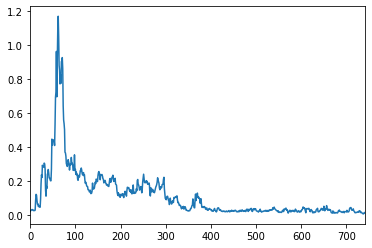

In [30]:
df2.aceite_Mbd.plot()

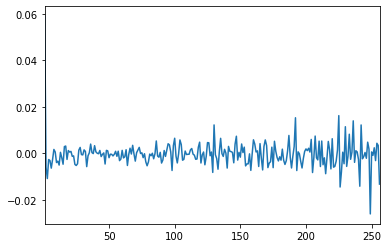

In [10]:
#create a new dataframe to model the difference
df_diff = df2.copy()

#add previous sales to the next row
df_diff['prev_Qo'] = df_diff['aceite_Mbd'].shift(1)

#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['aceite_Mbd'] - df_diff['prev_Qo']) 
df_diff['diff'].plot()

In [11]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_Qo'],axis=1)
#adding lags
for inc in range(1,51):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [12]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_6+'
                                +'lag_7+lag_8+lag_9+lag_10+lag_11+lag_12+'
                                +'lag_13+lag_14+lag_15+lag_16+lag_17+'
                                +'lag_18+lag_19+lag_20+lag_21+lag_22+'
                                +'lag_23+lag_24+lag_25+lag_26+lag_27+'
                                +'lag_28+lag_29+lag_30+lag_31+lag_32+'
                                +'lag_33+lag_34+lag_35+lag_36+lag_37+'
                                +'lag_38+lag_39+lag_40+lag_41+lag_42+'
                                +'lag_43+lag_44+lag_45+lag_46+lag_47+'
                                +'lag_48+lag_49+lag_50',
                                data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.24776198135994965


In [13]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler

df_model = df_supervised.drop(['aceite_Mbd','month'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-25].values, df_model[-25:].values

In [14]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [15]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [16]:
model = Sequential()
model.add(LSTM(100, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1070
Epoch 2/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0667
Epoch 3/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0602
Epoch 4/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0563
Epoch 5/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0530
Epoch 6/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0497
Epoch 7/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0461
Epoch 8/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0422
Epoch 9/100
181/181 [==============================] - 1s 3ms/step - loss: 0.0381
Epoch 10/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0339
Epoch 11/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0298
Epoch 12/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0262
Epoch 13/100


181/181 [==============================] - ETA: 0s - loss: 0.001 - 1s 4ms/step - loss: 0.0016
Epoch 100/100
181/181 [==============================] - 1s 4ms/step - loss: 0.0020


In [17]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1

In [18]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[-0.21794733 -0.4228782   0.68908224 -0.34825003 -0.02404854 -0.57760799
  -1.45839458  1.0761831  -0.15298126 -0.55192058 -0.7383236  -0.76711757
   0.25063239 -0.82831343 -0.14979774  0.15378574 -0.4045341  -1.0424284
  -0.46284652 -0.7152224   0.15013477 -0.78047566  0.14652    -0.5381905
  -0.46314362  0.33170402 -0.45810384 -1.00421792  0.20734798 -0.25531075
  -0.11635897 -0.20302868 -0.13983775 -0.23205418 -0.49021017 -0.83737784
  -0.59671167 -0.31961746 -0.24772804 -0.93137437  1.30218462  0.08691309
  -0.32083119 -0.81290777 -0.349914    0.55719151 -0.09270171 -0.50687209
  -0.47364807 -0.3179462  -0.63786262]]
[[ 0.60302114 -0.13861405 -0.4228782   0.68908224 -0.34825003 -0.02404854
  -0.93919147 -1.47585554  1.0761831  -0.15298126 -0.55192058 -0.7383236
  -0.76711757  0.25063239 -0.82831343 -0.14979774  0.15378574 -0.43433017
  -1.0424284  -0.46284652 -0.7152224   0.15013477 -0.78047566  0.14652
  -0.5381905  -0.46314362  0.33170402 -0.46117892 -1.00421792  0.20734798
  -0

In [19]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df2[50:].month)
#display(sales_dates)
act_sales = list(df2[50:].aceite_Mbd)
#display(act_sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['month'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
#for multistep prediction, replace act_sales with the predicted sales
#merge with actual sales dataframe
df_sales_pred = pd.merge(df2,df_result,on='month',how='left')

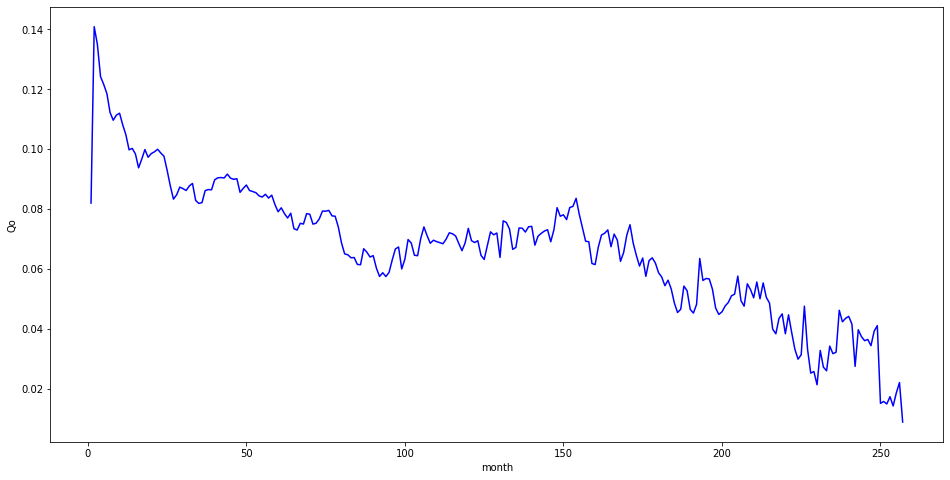

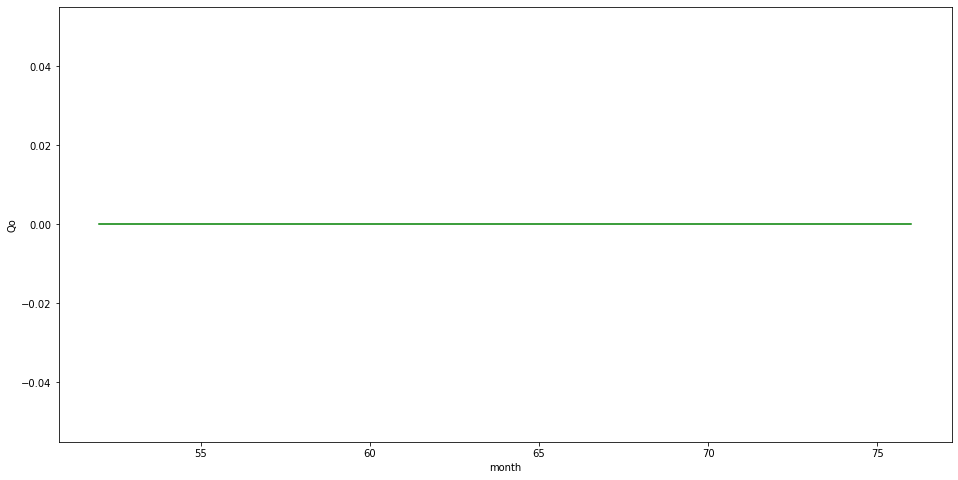

In [20]:
fig4, ax4 = plt.subplots(figsize=(16,8))
ax4.plot(df_sales_pred['month'],df_sales_pred['aceite_Mbd'],color='Blue')
ax4.set_xlabel('month')
ax4.set_ylabel('Qo')
plt.show()

fig5, ax5 = plt.subplots(figsize=(16,8))
ax5.plot(df_sales_pred['month'],df_sales_pred['pred_value'],color='Green')
ax5.set_xlabel('month')
ax5.set_ylabel('Qo')
plt.show()

Segmentar el df por dia de max produccion en adelante

# Change Point Detection

# Binary segmentation method

In [ ]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)

        model = "l2"  
        algo = rpt.Binseg(model=model).fit(points)
        my_bkps = algo.predict(n_bkps=1_000_000)
        # show results
        rpt.show.display(points, my_bkps, figsize=(10, 6),scalex=False)
        plt.title('Change Point Detection: Binary Segmentation Search Method')
        plt.show()

# Pelt search method

In [ ]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)

        model="rbf"
        algo = rpt.Pelt(model=model).fit(points)
        result = algo.predict(pen=1_000)
        rpt.display(points, result, figsize=(10, 6))
        plt.title('Change Point Detection: Pelt Search Method')
        plt.show()

# Dynamic programming search method

In [ ]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)

        model = "l1"  
        algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
        my_bkps = algo.predict(n_bkps=10)
        rpt.show.display(points, my_bkps, figsize=(10, 6))
        plt.title('Change Point Detection: Dynamic Programming Search Method')
        plt.show()

# Window-based search method

In [ ]:
unico=pd.unique(list(oil.pozo))
for pozo in unico:
        #Subset the dataframe by Well
        cpd_set=oil[oil.pozo==pozo]
        points=np.array(cpd_set.aceite_Mbd)
        
        model = "l2"  
        algo = rpt.Window(width=40, model=model).fit(points)
        my_bkps = algo.predict(n_bkps=1_000)
        rpt.show.display(points, my_bkps, figsize=(10, 6))
        plt.title('Change Point Detection: Window-Based Search Method')
        plt.show()

In [ ]:
from scipy import stats

outliers=[]
def detect_outlier(data_1):
    global z_score
    global outliers
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return z_score

In [ ]:
score=[]
def outlier_filter(data):
    global score
    global outliers
    threshold=3
    mean_1 = np.mean(data)
    std_1 =np.std(data)
    
    
    for y in data:
        z = (y - mean_1)/std_1 
        score.append(z)
    return score

In [ ]:
df=campo
outliers=outlier_filter(df.aceite_Mbd)


In [ ]:
display(score) 

In [36]:
display(fechas)

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               ...
               '2035-11-30', '2035-12-31', '2036-01-31', '2036-02-29', '2036-03-31', '2036-04-30', '2036-05-31', '2036-06-30', '2036-07-31', '2036-08-31'], dtype='datetime64[ns]', length=200, freq='M')

In [56]:
for mes in fechas:
    x=calendar.monthrange(mes[0],mes[1])
    display(x)

TypeError: 'Timestamp' object is not subscriptable

In [ ]:
mx_stats=pd.read_csv(r'C:\Users\elias\Downloads\Well_production/pozos.csv',
                         #index_col=1,
                         parse_dates=True,
                         #encoding='utf-8',
                         engine='python',
                         low_memory=True)

In [47]:
display(mx_stats.shape)

(2886837, 9)

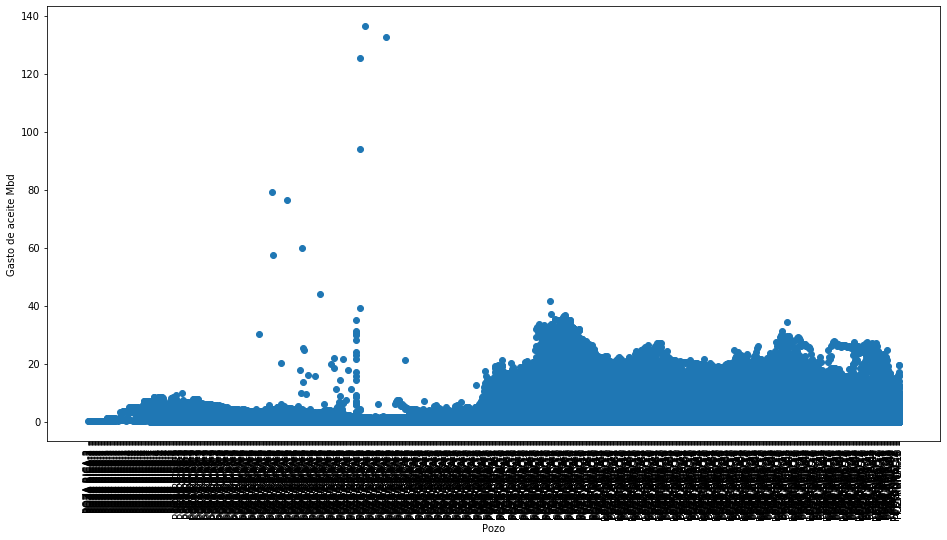

In [49]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(mx_stats.fecha,mx_stats.aceite_Mbd)
ax.set_xlabel('Pozo')
ax.set_xticklabels(labels=mx_stats.pozo,rotation=90)
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()